In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
# import http.cookiejar as cookielib
# import pandas as pd
# import requests
# import warnings
# import logging
# import sqlite3
# import boto3
# import glob
# import json
# import time
# import math
# import tqdm
# import sys
# import os

# sys.path.append("/opt/libs")
# from apiclass import APIClass,RedshiftClass
# from apikeyclass import APIkeyClass
# from dotenv import load_dotenv

from sc_experiments import *
from ts_experiments import *
from constants_and_utils import *

# import matplotlib.pyplot as plt 
# import numpy as np
# from scipy.stats.stats import pearsonr

In [4]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

## Battery-BMS Time Series

### Setup

In [5]:
# load bom dictionary, print bom['bms']
bom = parse_battery_bom()
bom =  {k.lower(): v for k, v in bom.items()}
print('num parts', len(bom))
print('BMS codes', bom['bms'])

num parts 16
BMS codes ['850450', '850730', '850780', '850790', '853222', '853223', '853321', '853340', '853630', '853641', '853890', '854190', '854239', '854290', '854411', '854442', '854449']


In [6]:
# Q: What are specific suppliers we should analyze?
# load battery_index: top battery supplier in terms of bill count from index_hs6
query = f"select supplier_t, SUM(bill_count)  AS battery_sum from index_hs6 WHERE hs6 LIKE '850760%' AND bill_count IS NOT NULL GROUP BY supplier_t ORDER BY SUM(bill_count) DESC;"
battery_index = rs.query_df(query)
display(battery_index)

supplier_t  battery_sum
0                                                  sevt        21289
1                                       dell global b.v         6061
2                                                  sdiv         5971
3                            amperex technology limited         4428
4                                   wistron corporation         3845
...                                                 ...          ...
4490                                ronda group co.,ltd            1
4491                    sporto tianjin bicycle co., ltd            1
4492                   teng xin da albert technology co            1
4493                                         x-rite inc            1
4494  cong ty tnhh dau tu thuong mai va dich vu hoan...            1

[4495 rows x 2 columns]

In [7]:
# Q: What are specific suppliers we should analyze?
# load bms_index: top bms buyer in terms of bill count from index_hs6
bms_codes_str = ""
for code in bom['bms']:
    bms_codes_str += f"{code}|"
bms_codes_str = f"'({bms_codes_str[:-1]})%'"
print(bms_codes_str)

bms_query = f"select supplier_t, SUM(bill_count) AS bms_sum from index_hs6 WHERE hs6 SIMILAR TO {bms_codes_str} AND bill_count IS NOT NULL GROUP BY supplier_t ORDER BY SUM(bill_count) DESC;"
bms_index = rs.query_df(bms_query)
display(bms_index)

'(850450|850730|850780|850790|853222|853223|853321|853340|853630|853641|853890|854190|854239|854290|854411|854442|854449)%'


supplier_t  bms_sum
0                        te connectivity solutions gmbh  2350361
1                                   ultra charm limited   139589
2                                    lg electronics inc   112440
3          cong ty tnhh dien tu samsung hcmc ce complex    87794
4                      tyco electronics middle east fze    69768
...                                                 ...      ...
4435  mitsubishi electric turkey elektrik urunleri a...        1
4436                             audi mexico s.a de c.v        1
4437                      m s rochester electronics llc        1
4438                        toa engineering corporation        1
4439                 samsung india electronics pvt. ltd        1

[4440 rows x 2 columns]

In [8]:
# Identify top battery supplier AND bms buyer (i.e. for both battery and bms separately over 100 bill count)
index = pd.merge(battery_index, bms_index,  how='inner', on=['supplier_t'])
index = index[(index['battery_sum'] > 100) & (index['bms_sum'] > 100)]
index.to_csv("company_names_parse.csv", sep=',')
display(index)

supplier_t  battery_sum  bms_sum
0                                                sevt        21289    15003
2                                                sdiv         5971      127
3                                 wistron corporation         3845    14815
4                               hp international sarl         2298     3757
5                                samsung sdi co., ltd         1706      145
6                      elentec vietnam energy co.,ltd         1509      195
7                   cong ty tnhh samsung sdi viet nam         1193      128
8                  itm semiconductor vietnam co., ltd         1013     9046
9                                                sehc          689    15454
10    samsung electronics vietnam thai nguyen co.,ltd          658      553
11       cong ty tnhh dien tu samsung hcmc ce complex          631    87794
13          cong ty tnhh samsung electronics viet nam          611     1991
14                       samsung electronics co., ltd          522    13752
15                      verdant crest technology dmcc          508    10921
16                         luxshare precision limited          437    25177
18                          apple south asia pte. ltd          409      149
19                    wingtech group hongkong limited          383    19866
20                          tti vietnam manufacturing          380      171
21                   arnold technologies shenzhen ltd          372     5585
23                                      no disponible          361     2029
25         hefei gotion high-tech power energy co ltd          341    10806
27               shenzhen chenshi technology co., ltd          286     4641
29         tcl technoly electronics hui zhou co., ltd          254    20444
30                 hansol electronics vietnam co.,ltd          215      278
33                        samsung sdi vietnam co.,ltd          201      258
34                                 lg electronics inc          183   112440
37  cong ty tnhh samsung electronics viet nam thai...          158    11665
38          lg electronics vietnam hai phong co., ltd          147    15928
41                        hp pps asia pacific pte ltd          139      108
42                              buckeye mountain, inc          138      140
43                                              lgevh          136     1345
44                            compal vietnam co., ltd          134     6910
46          itm semiconductor vietnam company limited          125     2179
53                       truper herramientas sa de cv          103      348
54                               apple operations ltd          102      432

### Get Data

In [9]:
# Warning: samsung takes significantly more time than other companies 
company_regex = ['samsung', 'wistron', 'hp', 'elentec', 'itm', 'verdant', 'luxshare', 'apple', 
                 'wingtech', 'lg', 'techtronic', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 
                 'tcl', 'hansol', 'buckeye', 'compal', 'truper']
SUPPLY_PROD='battery'
BUY_PROD='bms'

for regex in company_regex:
    companies = dict_regex[regex]
    print(f"Getting battery for {regex}")
    csv_name = get_transaction_df(PROD=SUPPLY_PROD, tx_type='supplier', companies=companies)
    print(f"Getting bms for {regex}")
    csv_name = get_transaction_df(PROD=BUY_PROD, tx_type='buyer', companies=companies)
    print("\n")

Getting battery for samsung
850760 -> 47426 47426
Getting bms for samsung
850450 -> 86582 86582
850730 -> 1 1
850780 -> 86 86
850790 -> 4680 4680
853222 -> 3537 3537
853223 -> 896 896
853321 -> 119285 119285
853340 -> 9184 9184
853630 -> 1320 1320
853641 -> 720 720
853890 -> 1982 1982
854190 -> 1 1
854239 -> 132787 132787
854290 -> 455 455
854411 -> 637 637
854442 -> 78900 78900
854449 -> 42055 42055


Getting battery for wistron
850760 -> 3848 3848
Getting bms for wistron
850450 -> 76 76
850730 -> None
850780 -> None
850790 -> None
853222 -> 11 11
853223 -> None
853321 -> 75 75
853340 -> 5 5
853630 -> None
853641 -> None
853890 -> None
854190 -> None
854239 -> 386 386
854290 -> None
854411 -> None
854442 -> 164 164
854449 -> 53 53


Getting battery for hp
850760 -> 4628 4628
Getting bms for hp
850450 -> None
850730 -> None
850780 -> 2 2
850790 -> None
853222 -> None
853223 -> None
853321 -> None
853340 -> 2 2
853630 -> None
853641 -> 7 7
853890 -> 7 7
854190 -> None
854239 -> 82 82
85

### Statistical Analysis
1. Companies that purchases BMS and sells battery
2. Signs of propagation? What time scale? Go into their transactions, plot out quarter by quarter, aggregated BMS, battery.
3. Correlation (Pearson): BMS, Battery time series

samsung: supply name is battery; buy name is bms
Supply len is 47426, buy len is 483108


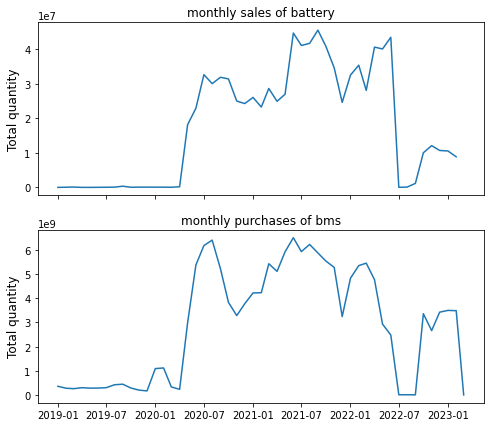

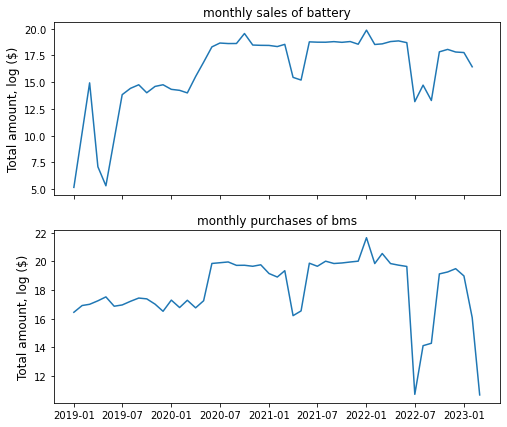

850450 86582 r=0.839 (n=48, p=0.000)
850730 1
850780 86
850790 4680 r=0.910 (n=35, p=0.000)
853222 3537 r=0.736 (n=39, p=0.000)
853223 896 r=-0.029 (n=29, p=0.882)
853321 119285 r=0.857 (n=46, p=0.000)
853340 9184 r=0.766 (n=47, p=0.000)
853630 1320 r=0.541 (n=45, p=0.000)
853641 720 r=0.653 (n=44, p=0.000)
853890 1982 r=0.832 (n=38, p=0.000)
854190 1
854239 132787 r=0.913 (n=48, p=0.000)
854290 455 r=0.105 (n=28, p=0.596)
854411 637 r=0.334 (n=35, p=0.050)
854442 78900 r=0.863 (n=48, p=0.000)
854449 42055 r=0.771 (n=45, p=0.000)


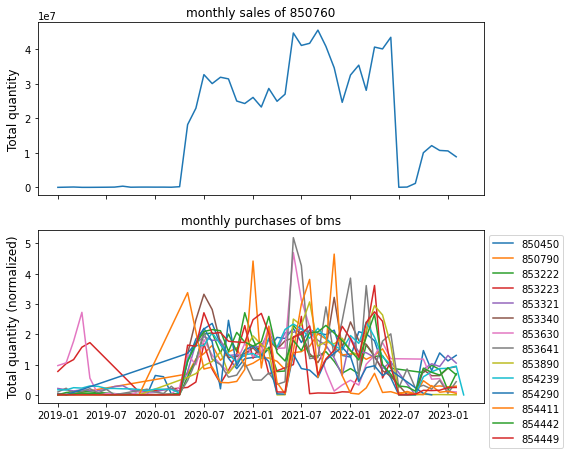

wistron: supply name is battery; buy name is bms
Supply len is 3848, buy len is 770


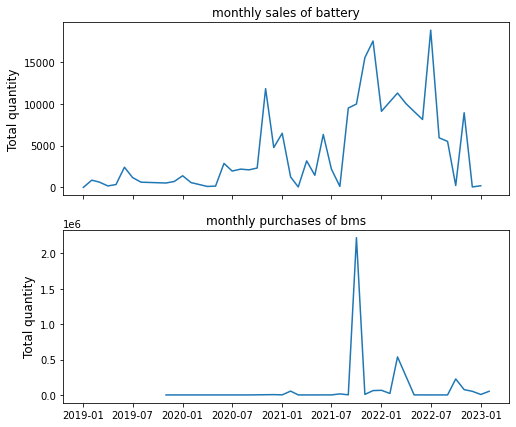

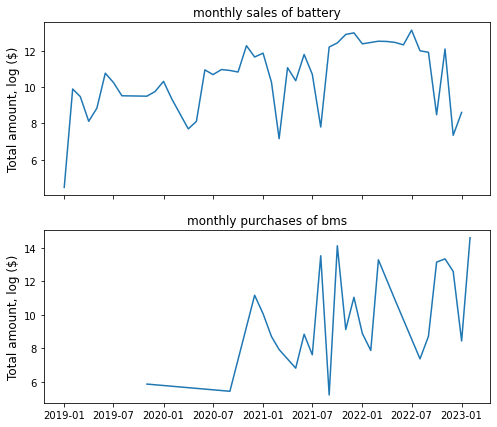

850450 76
850730 0
850780 0
850790 0
853222 11
853223 0
853321 75
853340 5
853630 0
853641 0
853890 0
854190 0
854239 386 r=0.251 (n=14, p=0.386)
854290 0
854411 0
854442 164 r=0.705 (n=16, p=0.002)
854449 53


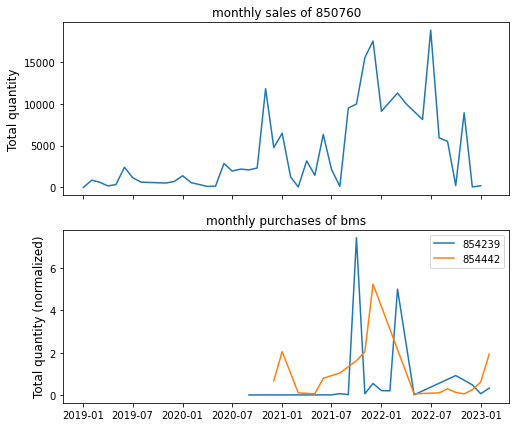

hp: supply name is battery; buy name is bms
Supply len is 4628, buy len is 15547


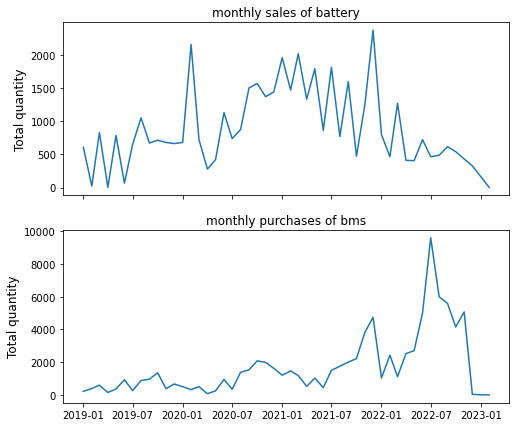

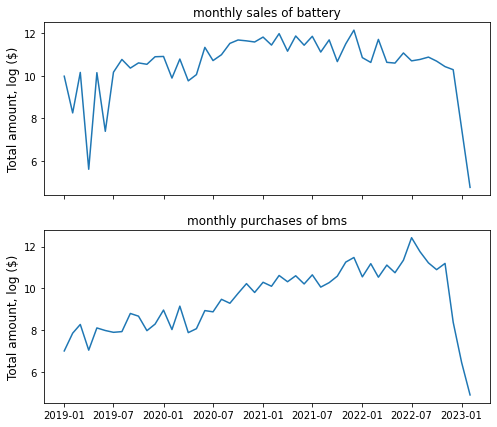

850450 0
850730 0
850780 2
850790 0
853222 0
853223 0
853321 0
853340 2
853630 0
853641 7
853890 7
854190 0
854239 82
854290 0
854411 0
854442 14042 r=0.005 (n=49, p=0.971)
854449 1405 r=-0.095 (n=47, p=0.524)


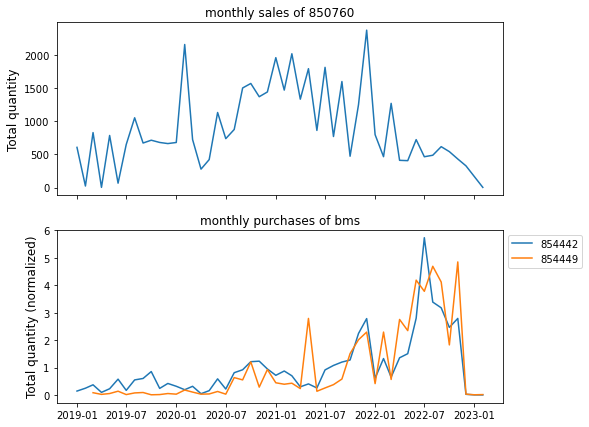

elentec: supply name is battery; buy name is bms
Supply len is 1996, buy len is 1319


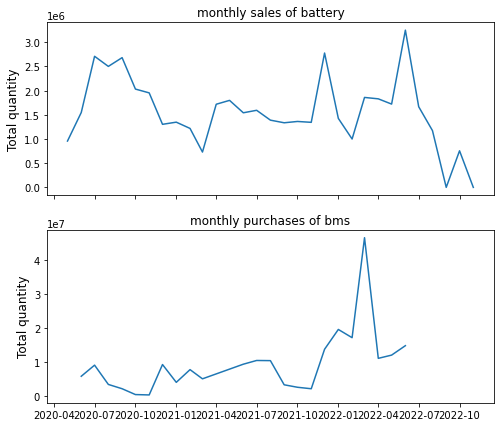

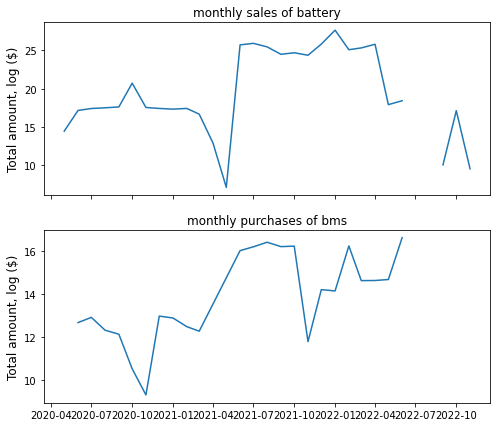

850450 63
850730 0
850780 0
850790 274 r=-0.135 (n=19, p=0.581)
853222 0
853223 0
853321 255 r=-0.060 (n=20, p=0.802)
853340 73
853630 0
853641 4
853890 0
854190 245 r=0.125 (n=23, p=0.569)
854239 307 r=0.196 (n=22, p=0.382)
854290 0
854411 0
854442 97
854449 1


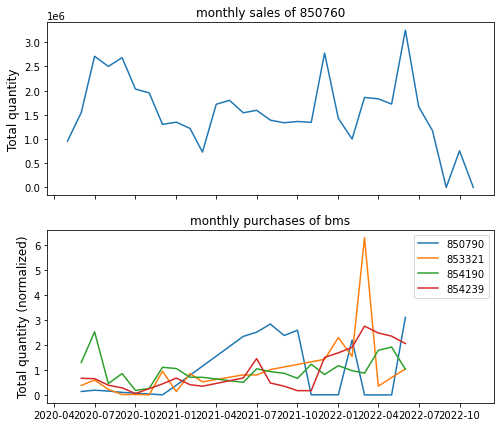

itm: supply name is battery; buy name is bms
Supply len is 1513, buy len is 17164


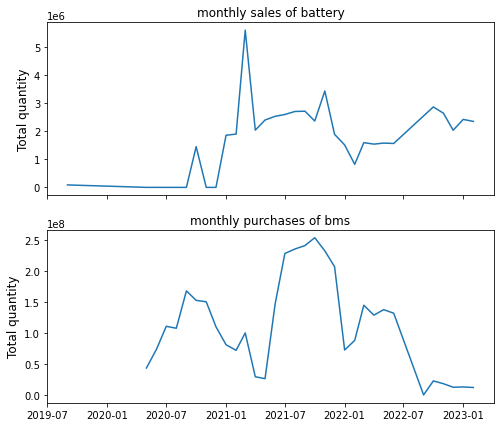

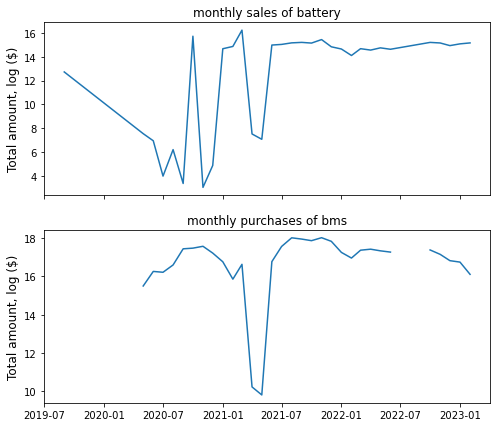

850450 16
850730 0
850780 3
850790 59
853222 0
853223 0
853321 0
853340 408 r=0.271 (n=26, p=0.180)
853630 135 r=0.597 (n=26, p=0.001)
853641 53
853890 148 r=0.349 (n=21, p=0.121)
854190 38
854239 8726 r=0.044 (n=31, p=0.814)
854290 6457 r=0.348 (n=31, p=0.055)
854411 18
854442 375 r=0.544 (n=24, p=0.006)
854449 728 r=-0.046 (n=27, p=0.821)


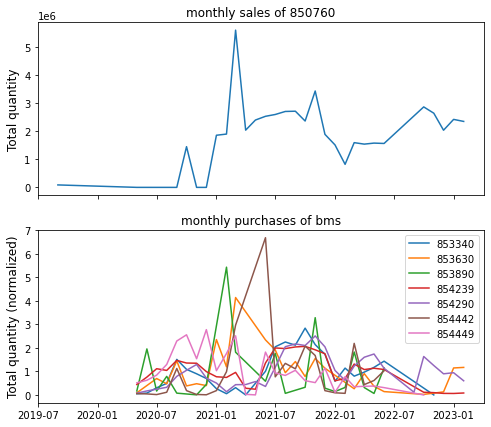

verdant: supply name is battery; buy name is bms
Early termination for verdant due to data shortage. 
luxshare: supply name is battery; buy name is bms
Supply len is 505, buy len is 515379


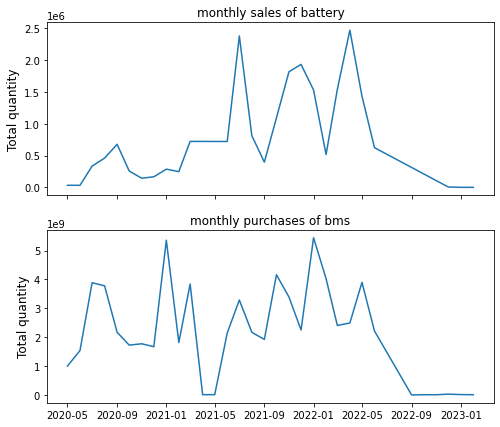

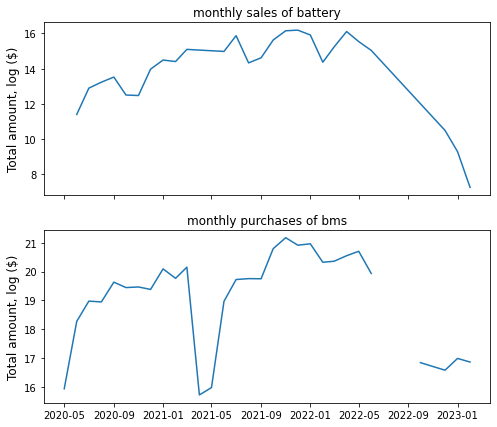

850450 18421 r=0.260 (n=26, p=0.199)
850730 0
850780 0
850790 0
853222 4489 r=-0.530 (n=23, p=0.009)
853223 2724 r=-0.324 (n=24, p=0.123)
853321 29626 r=0.333 (n=27, p=0.089)
853340 4
853630 0
853641 60
853890 7959 r=-0.384 (n=24, p=0.064)
854190 0
854239 34334 r=0.358 (n=27, p=0.067)
854290 10
854411 60
854442 18846 r=0.172 (n=27, p=0.390)
854449 16211 r=-0.348 (n=24, p=0.096)


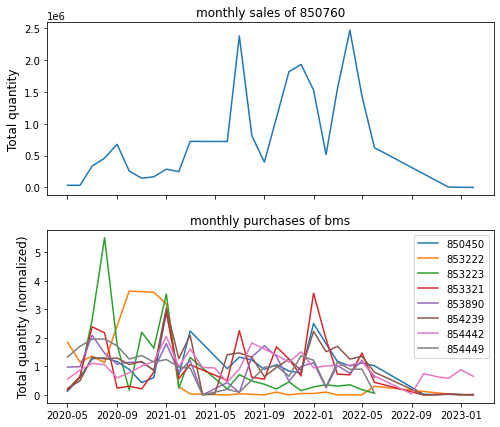

apple: supply name is battery; buy name is bms
Supply len is 887, buy len is 4925


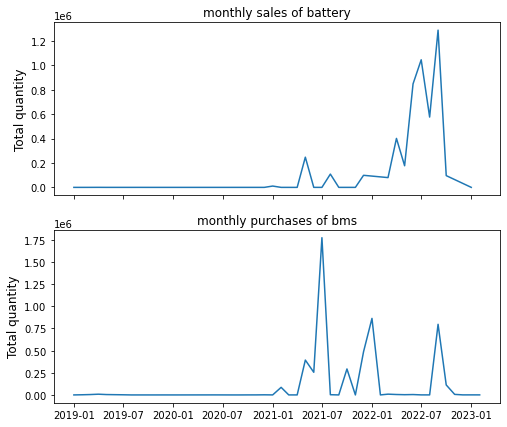

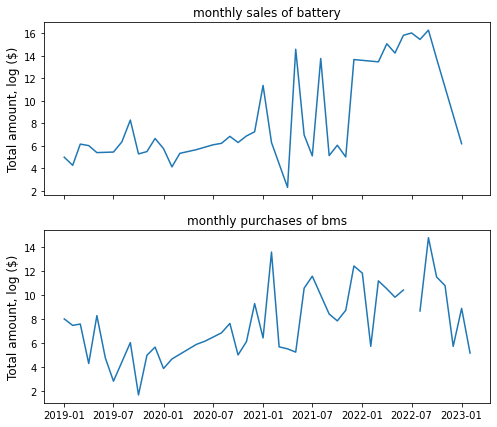

850450 9
850730 0
850780 0
850790 0
853222 1
853223 0
853321 32
853340 0
853630 0
853641 0
853890 12
854190 0
854239 57
854290 0
854411 0
854442 4812 r=0.631 (n=39, p=0.000)
854449 2


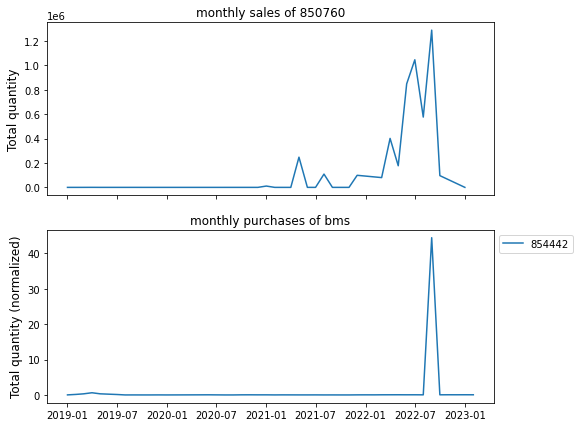

wingtech: supply name is battery; buy name is bms
Early termination for wingtech due to data shortage. 
lg: supply name is battery; buy name is bms
Supply len is 1260, buy len is 592000


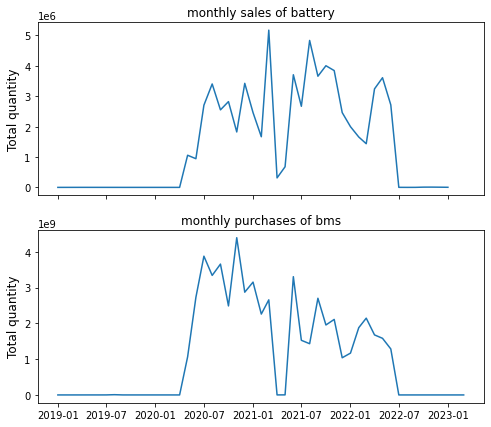

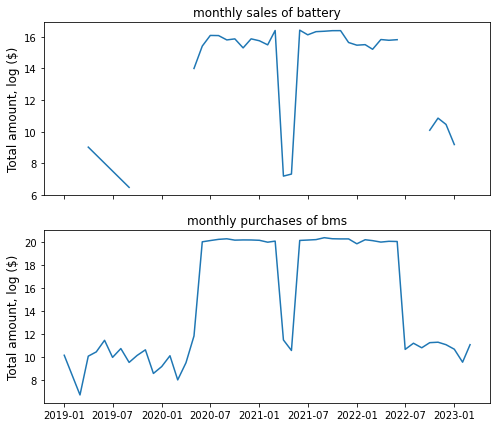

850450 76033 r=0.233 (n=29, p=0.224)
850730 2
850780 13
850790 20
853222 6146 r=0.200 (n=24, p=0.348)
853223 29
853321 110277 r=0.522 (n=27, p=0.005)
853340 6146 r=-0.238 (n=25, p=0.252)
853630 2
853641 189 r=0.022 (n=22, p=0.921)
853890 1097 r=0.210 (n=24, p=0.325)
854190 0
854239 8110 r=0.710 (n=37, p=0.000)
854290 4
854411 28
854442 15351 r=0.699 (n=33, p=0.000)
854449 115 r=-0.482 (n=21, p=0.027)


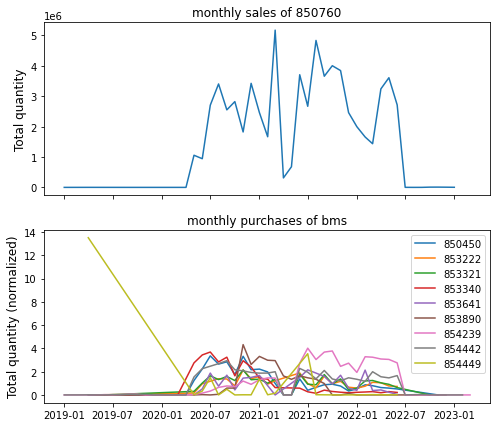

techtronic: supply name is battery; buy name is bms
Supply len is 804, buy len is 1487630


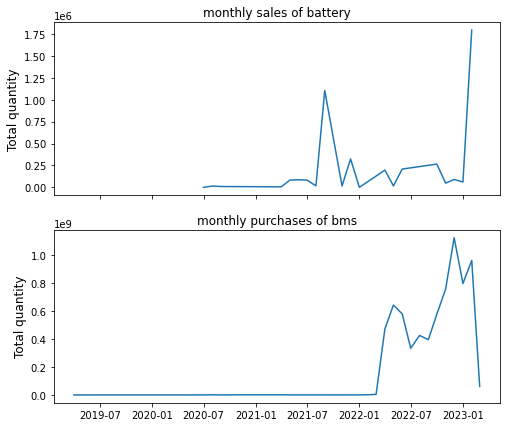

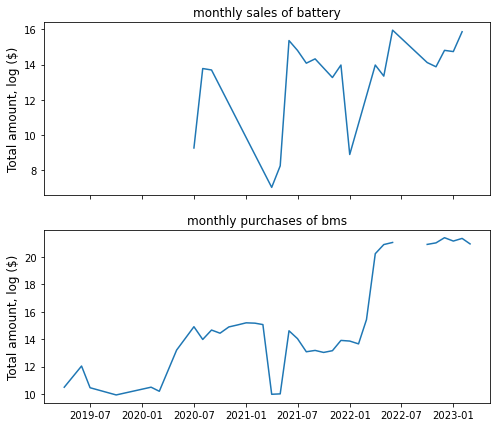

850450 23
850730 0
850780 0
850790 0
853222 1
853223 0
853321 0
853340 0
853630 0
853641 0
853890 25
854190 0
854239 1942 r=-0.064 (n=18, p=0.802)
854290 0
854411 471 r=-0.066 (n=14, p=0.822)
854442 5520 r=0.536 (n=18, p=0.022)
854449 1798 r=0.968 (n=15, p=0.000)


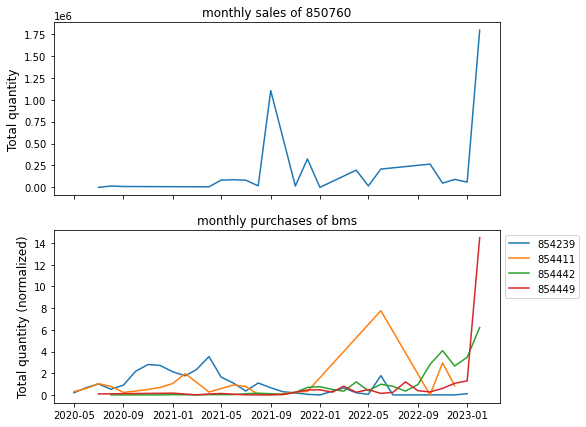

arnold: supply name is battery; buy name is bms
Early termination for arnold due to data shortage. 
hefei_gotion: supply name is battery; buy name is bms
Early termination for hefei_gotion due to data shortage. 
shenzhen_chenshi: supply name is battery; buy name is bms
Early termination for shenzhen_chenshi due to data shortage. 
tcl: supply name is battery; buy name is bms
Early termination for tcl due to data shortage. 
hansol: supply name is battery; buy name is bms
Supply len is 215, buy len is 144


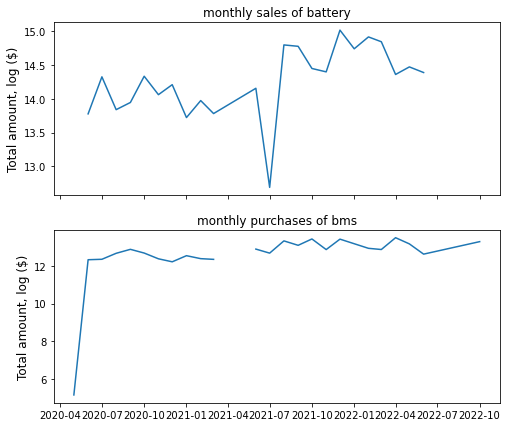

850450 0
850730 0
850780 0
850790 0
853222 0
853223 0
853321 0
853340 3
853630 1
853641 2
853890 0
854190 0
854239 18
854290 0
854411 0
854442 119 r=0.360 (n=23, p=0.091)
854449 1


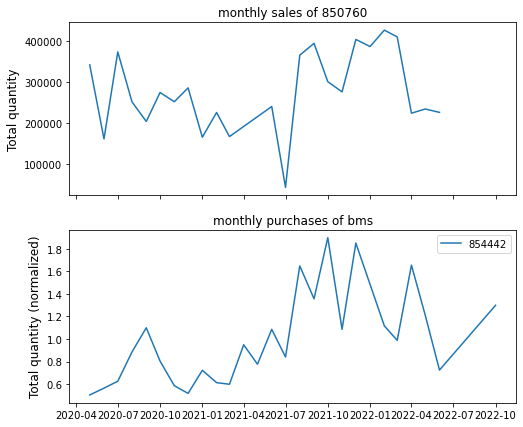

buckeye: supply name is battery; buy name is bms
Early termination for buckeye due to data shortage. 
compal: supply name is battery; buy name is bms
Supply len is 244, buy len is 9009


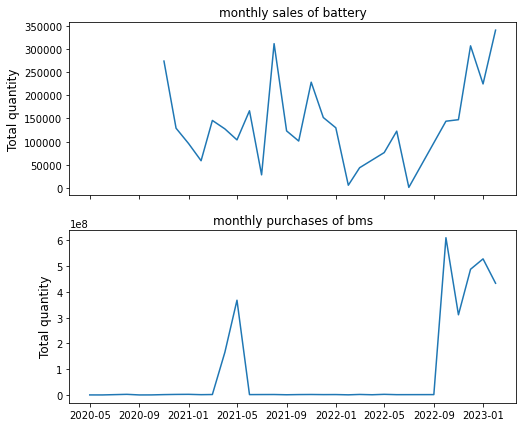

850450 2349 r=0.730 (n=11, p=0.011)
850730 0
850780 0
850790 0
853222 15
853223 0
853321 4249 r=0.544 (n=11, p=0.084)
853340 6
853630 0
853641 11
853890 0
854190 0
854239 1632 r=-0.132 (n=24, p=0.540)
854290 1
854411 6
854442 659 r=0.570 (n=21, p=0.007)
854449 81


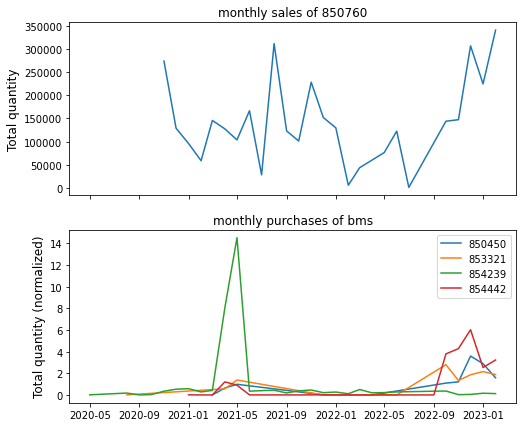

truper: supply name is battery; buy name is bms
Supply len is 228, buy len is 1372


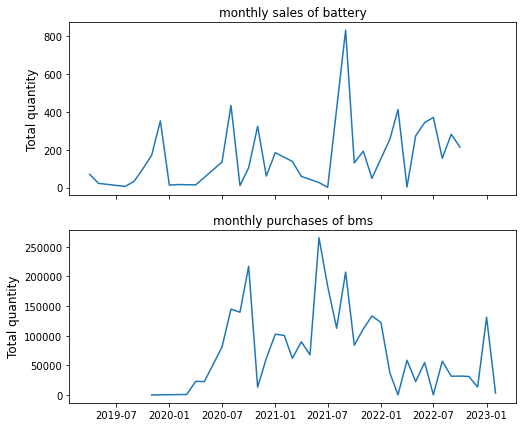

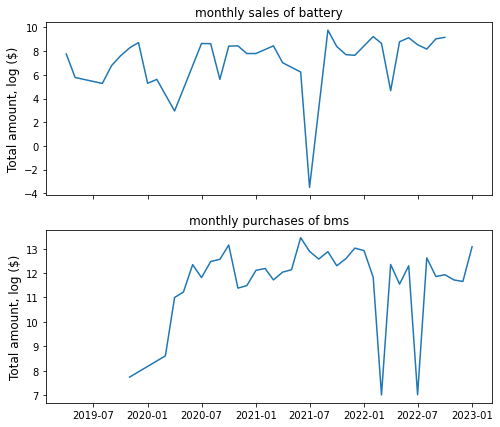

850450 3
850730 1
850780 1
850790 0
853222 0
853223 113 r=0.339 (n=15, p=0.217)
853321 0
853340 13
853630 5
853641 3
853890 105 r=-0.008 (n=17, p=0.975)
854190 0
854239 10
854290 0
854411 0
854442 960 r=-0.065 (n=25, p=0.759)
854449 158 r=0.047 (n=20, p=0.844)


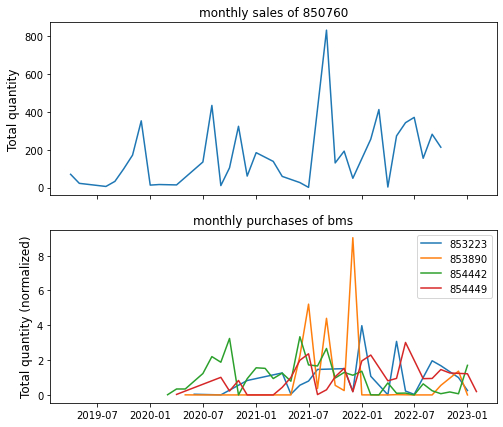

In [14]:
# 'verdant', 'wingtech', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 'tcl', 'hansol', 'buckeye',
# company_regex = ['samsung', 'wistron', 'hp', 'elentec', 'itm', 'luxshare', 
#              'apple', 'lg', 'techtronic', 'compal', 'truper']

company_regex = ['samsung', 'wistron', 'hp', 'elentec', 'itm', 'verdant', 'luxshare', 'apple', 
                 'wingtech', 'lg', 'techtronic', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 
                 'tcl', 'hansol', 'buckeye', 'compal', 'truper']
temp = []
SUPPLY_PROD='battery'
BUY_PROD='bms'

for csv_name in company_regex:
    supply_df, buy_df, early_termination = get_supply_buy_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
    if early_termination:
        print(f"Early termination for {csv_name} due to data shortage. ")
        continue
    temp.append(csv_name)
    
    supply_df, buy_df = add_transaction_time(supply_df=supply_df, buy_df=buy_df)
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly', csv_name=csv_name)
    summary_df = compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="monthly", csv_name=csv_name)
    summary_df = pd.DataFrame(summary_df, index=[0])
    summary_df.to_csv(f"./summary/{csv_name}_summary.csv", sep=',')
    del supply_df, buy_df

In [15]:
company_regex = temp.copy()
print(company_regex)
del temp

['samsung', 'wistron', 'hp', 'elentec', 'itm', 'luxshare', 'apple', 'lg', 'techtronic', 'hansol', 'compal', 'truper']


### Smoothing Analysis

samsung: supply name is battery; buy name is bms
Supply len is 47426, buy len is 483108


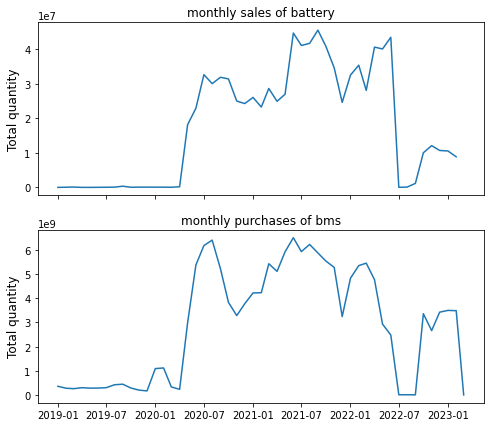

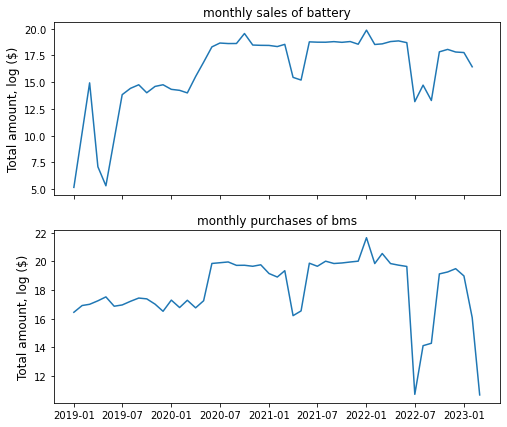

850450 86582 r=0.465 (n=859, p=0.000)
850730 1
850780 86
850790 4680 r=0.528 (n=360, p=0.000)
853222 3537 r=0.008 (n=534, p=0.850)
853223 896 r=0.213 (n=150, p=0.009)
853321 119285 r=0.445 (n=812, p=0.000)
853340 9184 r=0.194 (n=732, p=0.000)
853630 1320 r=0.309 (n=473, p=0.000)
853641 720 r=0.200 (n=373, p=0.000)
853890 1982 r=0.481 (n=537, p=0.000)
854190 1
854239 132787 r=0.767 (n=942, p=0.000)
854290 455 r=-0.117 (n=262, p=0.059)
854411 637 r=0.395 (n=226, p=0.000)
854442 78900 r=0.607 (n=931, p=0.000)
854449 42055 r=0.382 (n=739, p=0.000)


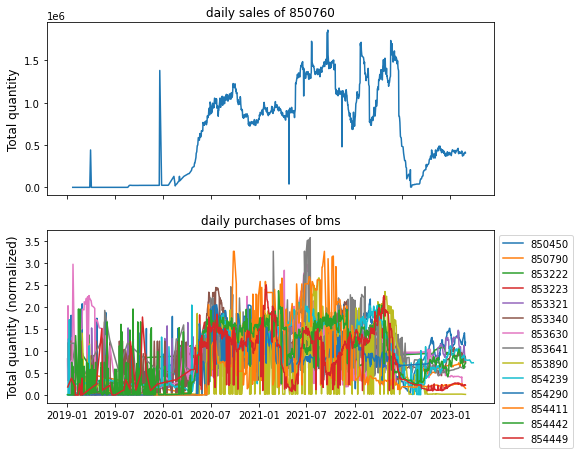

wistron: supply name is battery; buy name is bms
Supply len is 3848, buy len is 770


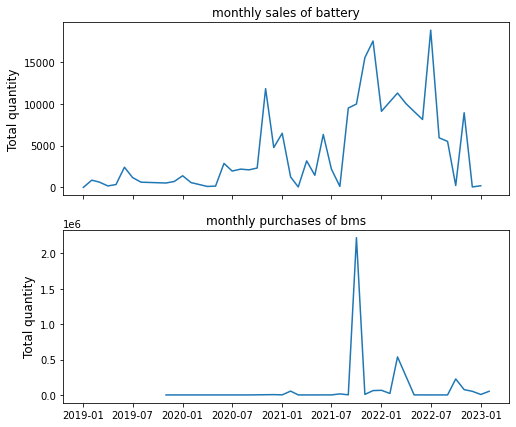

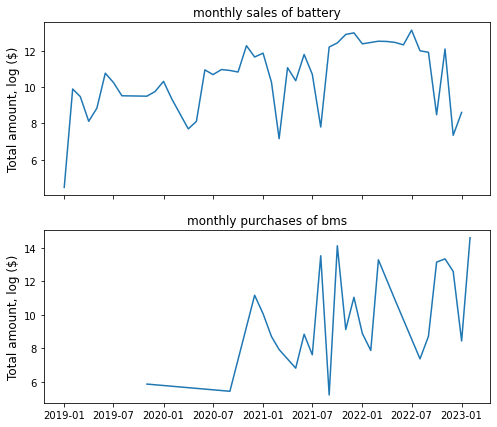

850450 76
850730 0
850780 0
850790 0
853222 11
853223 0
853321 75
853340 5
853630 0
853641 0
853890 0
854190 0
854239 386 r=-0.905 (n=3, p=0.280)
854290 0
854411 0
854442 164 r=0.377 (n=4, p=0.623)
854449 53


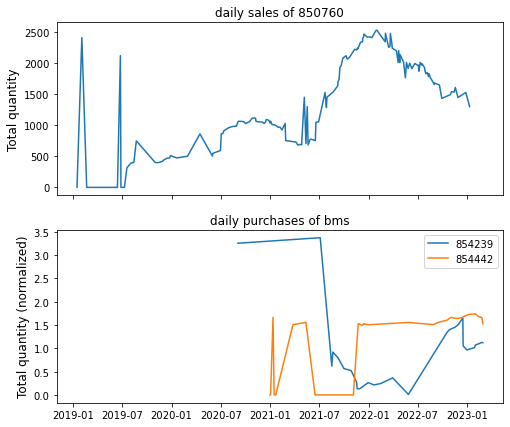

hp: supply name is battery; buy name is bms
Supply len is 4628, buy len is 15547


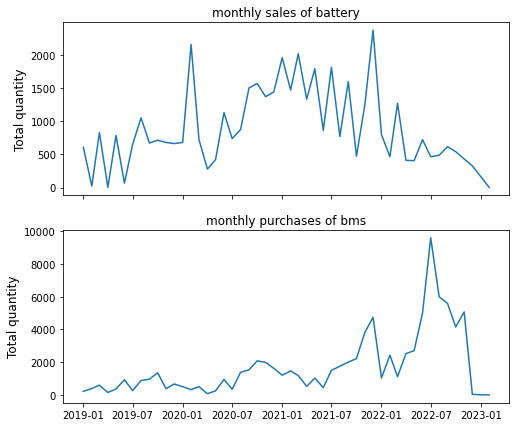

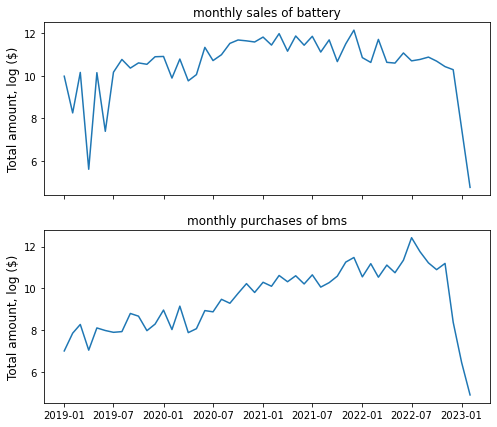

850450 0
850730 0
850780 2
850790 0
853222 0
853223 0
853321 0
853340 2
853630 0
853641 7
853890 7
854190 0
854239 82
854290 0
854411 0
854442 14042 r=-0.119 (n=211, p=0.085)
854449 1405 r=0.020 (n=104, p=0.837)


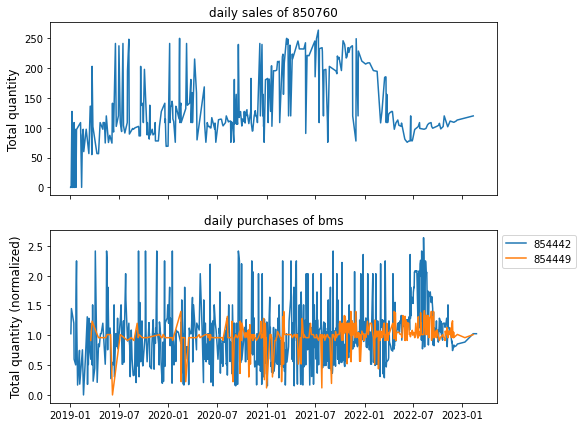

elentec: supply name is battery; buy name is bms
Supply len is 1996, buy len is 1319


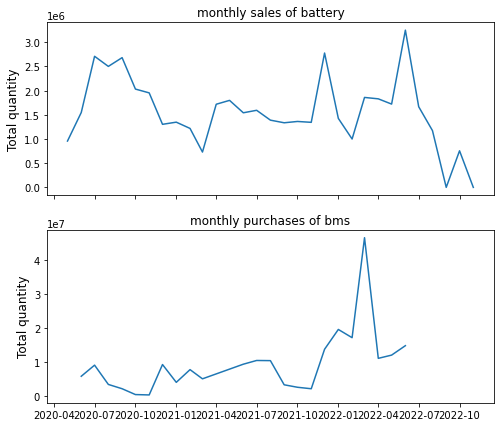

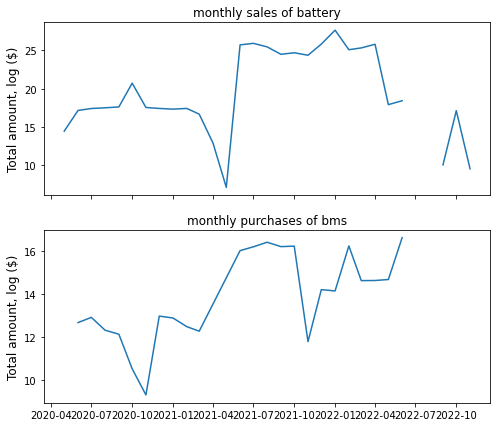

850450 63
850730 0
850780 0
850790 274 r=0.855 (n=10, p=0.002)
853222 0
853223 0
853321 255 r=0.712 (n=12, p=0.009)
853340 73
853630 0
853641 4
853890 0
854190 245 r=0.518 (n=11, p=0.103)
854239 307 r=0.667 (n=23, p=0.001)
854290 0
854411 0
854442 97
854449 1


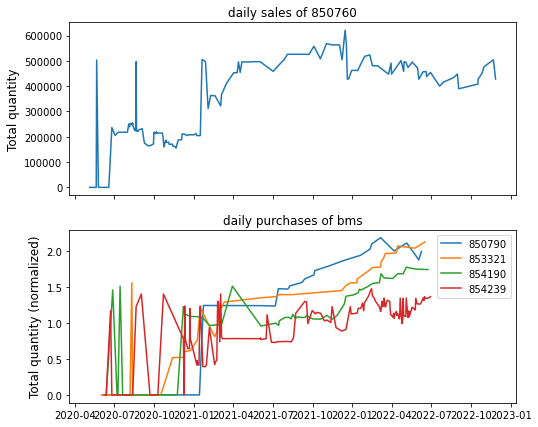

itm: supply name is battery; buy name is bms
Supply len is 1513, buy len is 17164


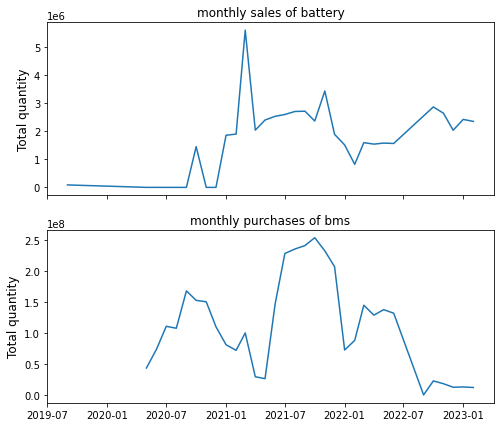

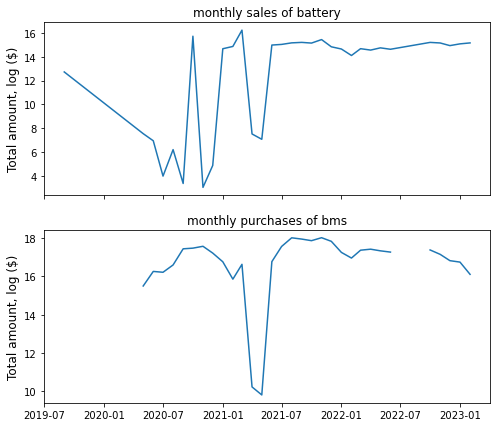

850450 16
850730 0
850780 3
850790 59
853222 0
853223 0
853321 0
853340 408 r=0.086 (n=125, p=0.341)
853630 135 r=0.433 (n=69, p=0.000)
853641 53
853890 148 r=-0.435 (n=39, p=0.006)
854190 38
854239 8726 r=-0.032 (n=411, p=0.512)
854290 6457 r=-0.178 (n=427, p=0.000)
854411 18
854442 375 r=0.551 (n=75, p=0.000)
854449 728 r=0.394 (n=129, p=0.000)


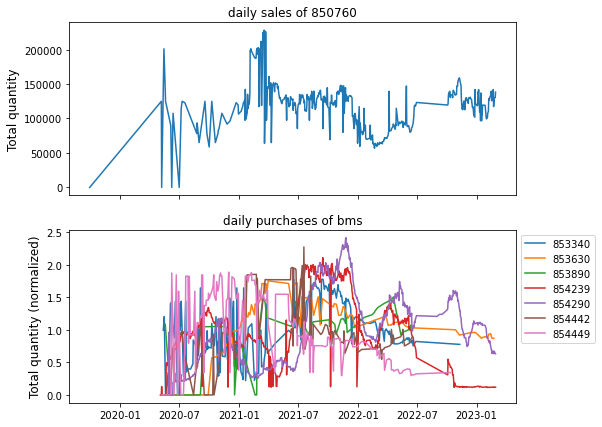

luxshare: supply name is battery; buy name is bms
Supply len is 505, buy len is 515379


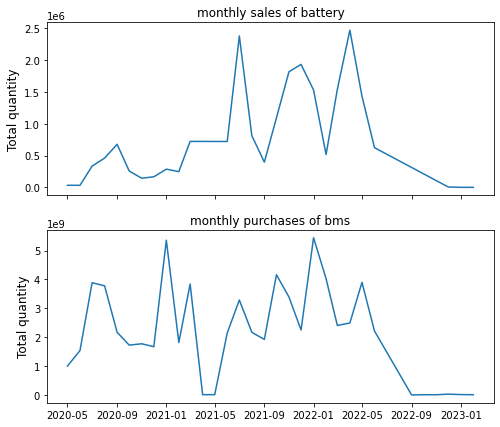

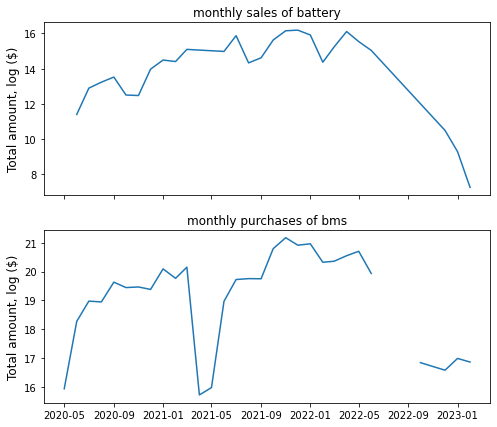

850450 18421 r=0.128 (n=124, p=0.156)
850730 0
850780 0
850790 0
853222 4489 r=-0.305 (n=27, p=0.121)
853223 2724 r=-0.658 (n=48, p=0.000)
853321 29626 r=0.538 (n=74, p=0.000)
853340 4
853630 0
853641 60
853890 7959 r=0.465 (n=86, p=0.000)
854190 0
854239 34334 r=-0.017 (n=177, p=0.819)
854290 10
854411 60
854442 18846 r=-0.127 (n=190, p=0.080)
854449 16211 r=-0.186 (n=116, p=0.045)


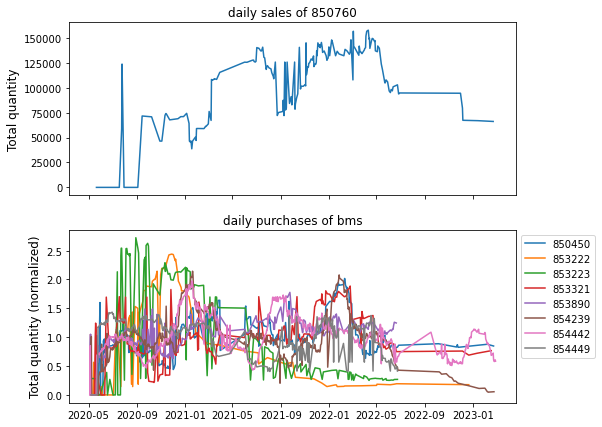

apple: supply name is battery; buy name is bms
Supply len is 887, buy len is 4925


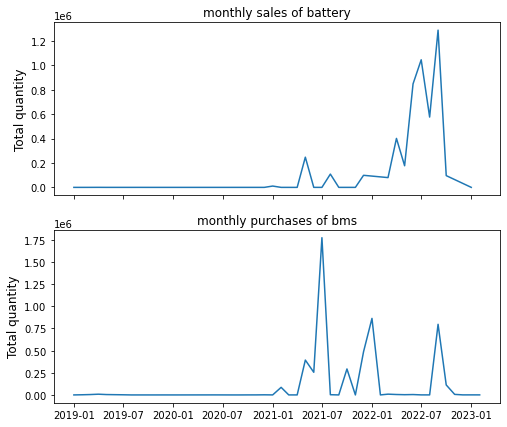

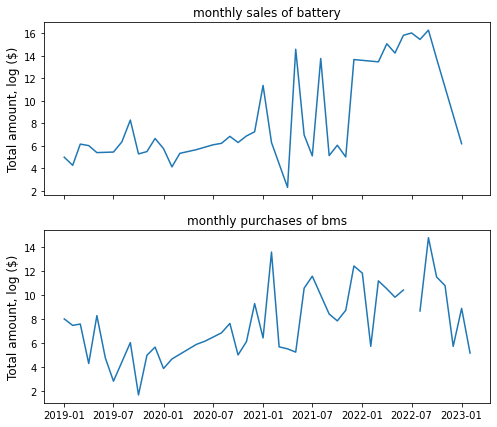

850450 9
850730 0
850780 0
850790 0
853222 1
853223 0
853321 32
853340 0
853630 0
853641 0
853890 12
854190 0
854239 57
854290 0
854411 0
854442 4812 r=0.225 (n=105, p=0.021)
854449 2


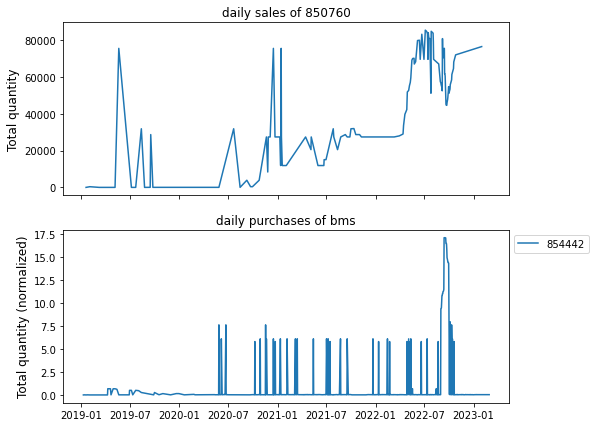

lg: supply name is battery; buy name is bms
Supply len is 1260, buy len is 592000


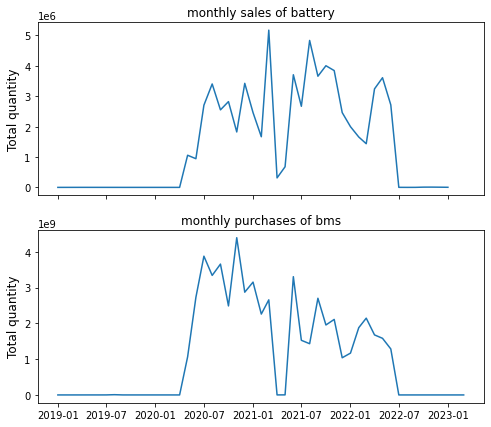

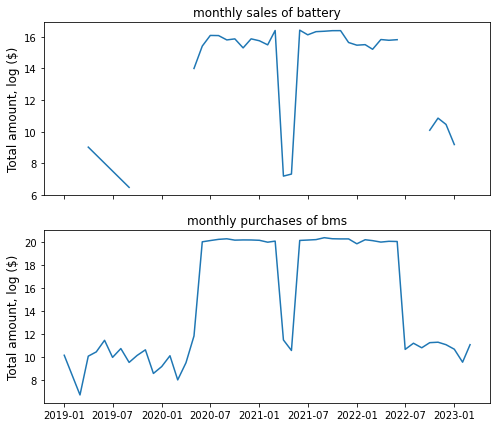

850450 76033 r=-0.012 (n=371, p=0.818)
850730 2
850780 13
850790 20
853222 6146 r=0.446 (n=281, p=0.000)
853223 29
853321 110277 r=0.417 (n=370, p=0.000)
853340 6146 r=-0.081 (n=305, p=0.159)
853630 2
853641 189 r=0.390 (n=45, p=0.008)
853890 1097 r=-0.115 (n=160, p=0.148)
854190 0
854239 8110 r=0.391 (n=353, p=0.000)
854290 4
854411 28
854442 15351 r=0.012 (n=394, p=0.818)
854449 115 r=0.025 (n=33, p=0.888)


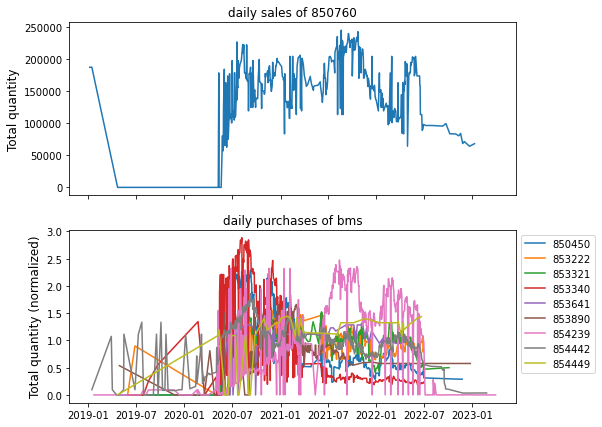

techtronic: supply name is battery; buy name is bms
Supply len is 804, buy len is 1487630


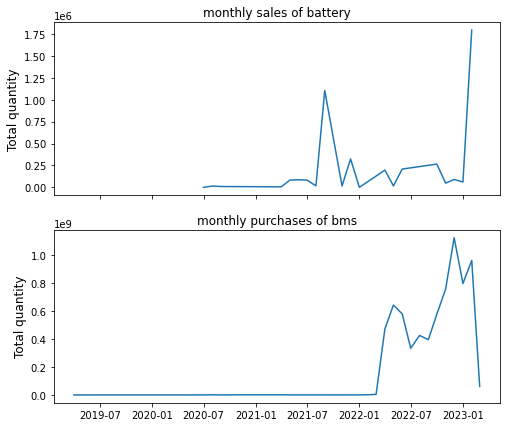

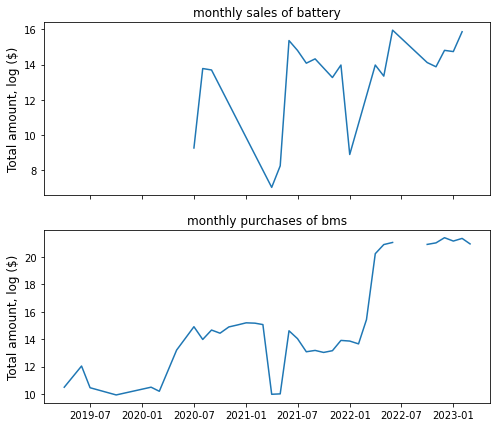

850450 23
850730 0
850780 0
850790 0
853222 1
853223 0
853321 0
853340 0
853630 0
853641 0
853890 25
854190 0
854239 1942 r=-0.120 (n=60, p=0.361)
854290 0
854411 471 r=0.534 (n=11, p=0.091)
854442 5520 r=0.337 (n=77, p=0.003)
854449 1798 r=0.535 (n=40, p=0.000)


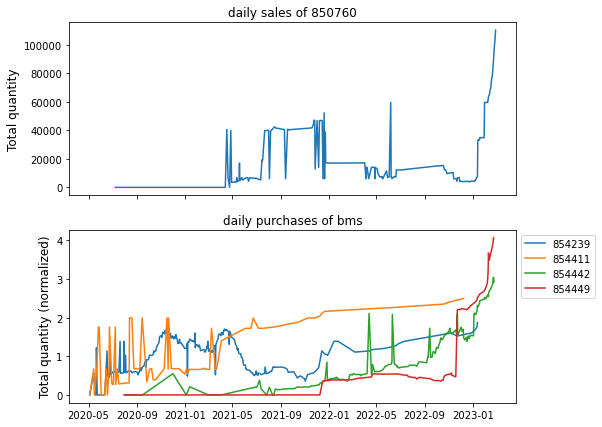

hansol: supply name is battery; buy name is bms
Supply len is 215, buy len is 144


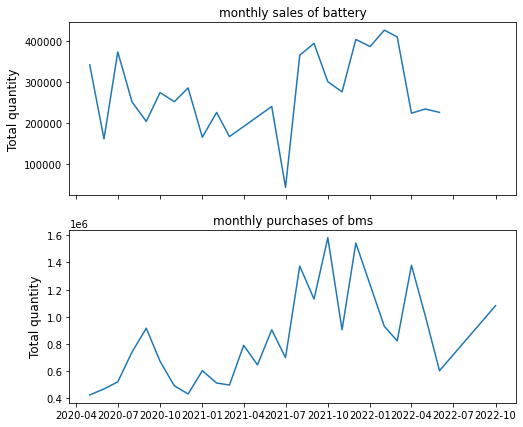

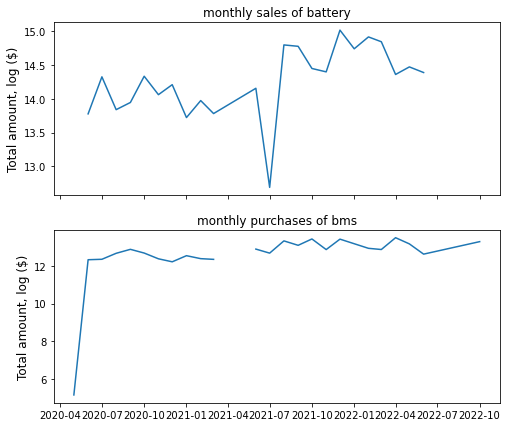

850450 0
850730 0
850780 0
850790 0
853222 0
853223 0
853321 0
853340 3
853630 1
853641 2
853890 0
854190 0
854239 18
854290 0
854411 0
854442 119 r=-0.833 (n=3, p=0.373)
854449 1


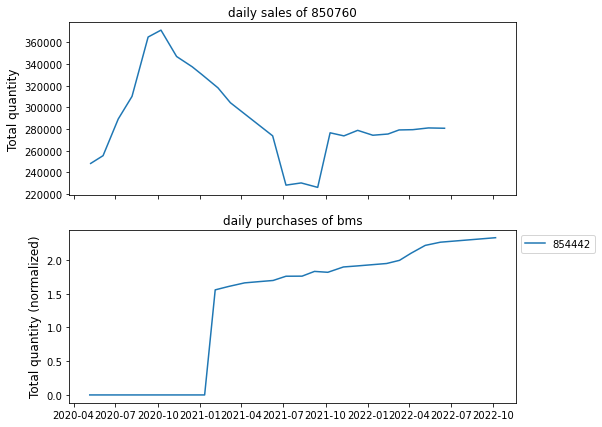

compal: supply name is battery; buy name is bms
Supply len is 244, buy len is 9009


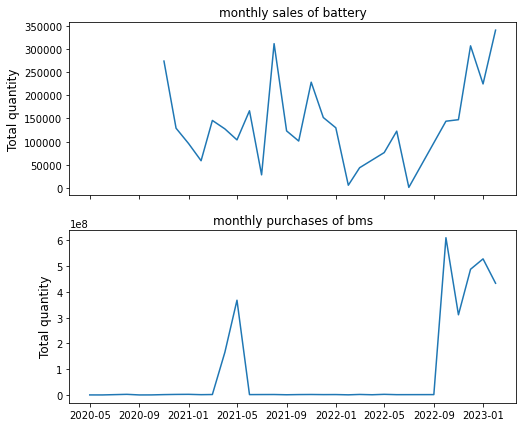

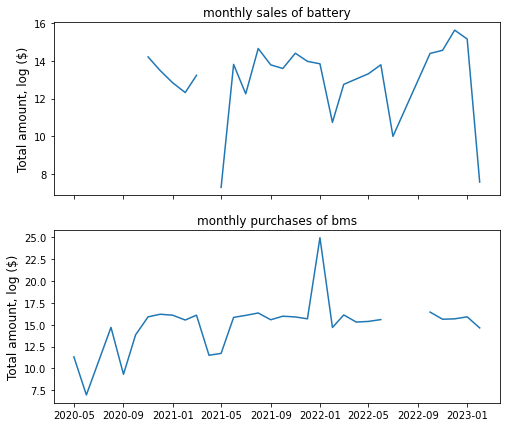

850450 2349 r=0.622 (n=34, p=0.000)
850730 0
850780 0
850790 0
853222 15
853223 0
853321 4249 r=0.677 (n=34, p=0.000)
853340 6
853630 0
853641 11
853890 0
854190 0
854239 1632 r=-0.084 (n=42, p=0.595)
854290 1
854411 6
854442 659 r=0.712 (n=33, p=0.000)
854449 81


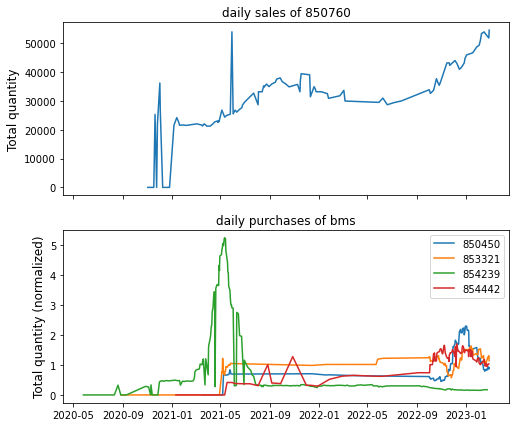

truper: supply name is battery; buy name is bms
Supply len is 228, buy len is 1372


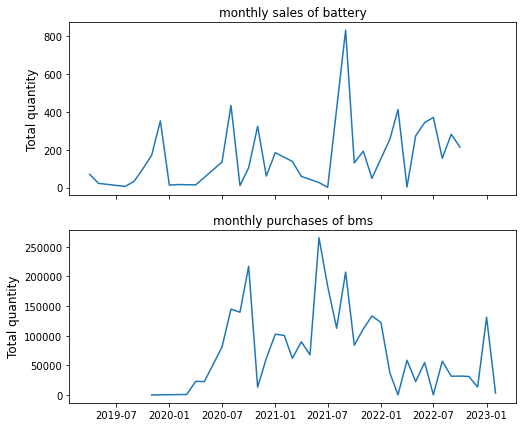

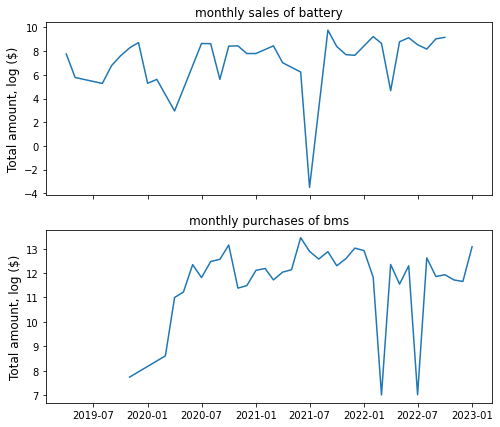

850450 3
850730 1
850780 1
850790 0
853222 0
853223 113 r=-0.070 (n=7, p=0.881)
853321 0
853340 13
853630 5
853641 3
853890 105 r=-0.942 (n=5, p=0.017)
854190 0
854239 10
854290 0
854411 0
854442 960 r=0.324 (n=33, p=0.066)
854449 158 r=-0.384 (n=6, p=0.453)


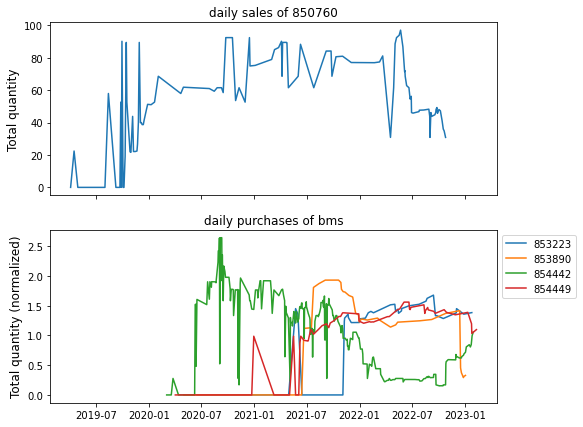

In [16]:
# 'verdant', 'wingtech', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 'tcl', 'hansol', 'buckeye',
# companies = ['samsung', 'wistron', 'hp', 'elentec', 'itm', 'luxshare', 
#              'apple', 'lg', 'techtronic', 'compal', 'truper']
temp = []
SUPPLY_PROD='battery'
BUY_PROD='bms'
num_before, num_after = 15, 15

for csv_name in company_regex:
    supply_df, buy_df, early_termination = get_supply_buy_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
    if early_termination:
        print(f"Early termination for {csv_name} due to data shortage. ")
        continue
    temp.append(csv_name)
    
    supply_df, buy_df = add_transaction_time(supply_df=supply_df, buy_df=buy_df)
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly', csv_name=csv_name)
    summary_df = compare_sale_purchase_quantity_per_hscode_smooth(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, 
                                                                  time='daily', num_before=num_before, num_after=num_after, csv_name=csv_name)
    summary_df = pd.DataFrame(summary_df, index=[0])
    summary_df.to_csv(f"./summary/{csv_name}_smooth_{num_before}-{num_after}_summary.csv", sep=',')
    del supply_df, buy_df

In [17]:
company_regex = temp.copy()
print(company_regex)
del temp

['samsung', 'wistron', 'hp', 'elentec', 'itm', 'luxshare', 'apple', 'lg', 'techtronic', 'hansol', 'compal', 'truper']


## Battery-Baseline Time Series

### Discover baseline options

In [18]:
# load index: top 100 supplier in terms of bill_count
query = f"select hs6, SUM(bill_count) from index_hs6 WHERE bill_count IS NOT NULL GROUP BY hs6 ORDER BY SUM(bill_count) DESC LIMIT 100;"
index = rs.query_df(query)

# load hs_category_description table
query = f"select * from hs_category_description"
hs_index = rs.query_df(query)

# Merge index and hs_category_description table
baseline_option = index.merge(hs_index, how='left', on='hs6').head(50)
display(baseline_option)

# Alternative: bms percetile among all products in terms of r-value

hs6      sum                                           category   
0   853690  2693959                 Electrical Machinery and Equipment  \
1   853890  2205674                 Electrical Machinery and Equipment   
2   392690  1464688                      Plastics and Articles Thereof   
3   851770   949306                 Electrical Machinery and Equipment   
4   854720   878331                 Electrical Machinery and Equipment   
5   940190   738867  Furniture; bedding, mattresses, mattress supports   
6   732690   732199                          Articles of Iron or Steel   
7   853669   671801                 Electrical Machinery and Equipment   
8   853610   640126                 Electrical Machinery and Equipment   
9   870899   619546             Vehicles Other Than Railway or Tramway   
10  940120   598709  Furniture; bedding, mattresses, mattress supports   
11  391990   577564                      Plastics and Articles Thereof   
12  731815   558260                          Articles of Iron or Steel   
13  940199   539939                                                NaN   
14  854790   461931                 Electrical Machinery and Equipment   
15  870829   413799             Vehicles Other Than Railway or Tramway   
16  401699   394893                        Rubber and Articles Thereof   
17  851712   383863                 Electrical Machinery and Equipment   
18  401693   382127                        Rubber and Articles Thereof   
19  847330   361377  Nuclear Reactors, Boilers, Machinery, and Mech...   
20  850450   345904                 Electrical Machinery and Equipment   
21  854430   335041                 Electrical Machinery and Equipment   
22  481910   314837  Paper and Paperboard; Articles of Paper Pulp, ...   
23  854442   303692                 Electrical Machinery and Equipment   
24  854690   299701                 Electrical Machinery and Equipment   
25  852990   297570                 Electrical Machinery and Equipment   
26  401695   269949                        Rubber and Articles Thereof   
27  854449   269130                 Electrical Machinery and Equipment   
28  853321   266241                 Electrical Machinery and Equipment   
29  391732   255120                      Plastics and Articles Thereof   
30  630790   247553                                           Footwear   
31  870880   228574             Vehicles Other Than Railway or Tramway   
32  854239   222961                 Electrical Machinery and Equipment   
33  853224   215257                 Electrical Machinery and Equipment   
34  851762   212588                 Electrical Machinery and Equipment   
35  853590   211377                 Electrical Machinery and Equipment   
36  848120   189222  Nuclear Reactors, Boilers, Machinery, and Mech...   
37  850440   185267                 Electrical Machinery and Equipment   
38  392630   183618                      Plastics and Articles Thereof   
39  854231   180297                 Electrical Machinery and Equipment   
40  853710   165102                 Electrical Machinery and Equipment   
41  761699   155754                      Aluminum and Articles Thereof   
42  870821   154838             Vehicles Other Than Railway or Tramway   
43  853650   150476                 Electrical Machinery and Equipment   
44  853641   148457                 Electrical Machinery and Equipment   
45  830242   147435               Miscellaneous Articles of Base Metal   
46  853400   143538                 Electrical Machinery and Equipment   
47  980100   142139                                                NaN   
48  490199   140633  Printed Books, Newspapers, Pictures and Other ...   
49  482390   140436  Paper and Paperboard; Articles of Paper Pulp, ...   

                                         sub_category   
0                                Electrical apparatus  \
1                                Electrical apparatus   
2                                            Plastics   
3   

In [19]:
BASELINE_PROD = ('853710', '830242', '630790', '848120', '490199',)

### Get Data (Baseline-Only)

In [20]:
for regex in company_regex:    
    companies = dict_regex[regex]
    print(f"Getting baseline for {regex}")
    csv_name = get_transaction_df(PROD=BASELINE_PROD, tx_type='buyer', companies=companies)
    print("\n")

Getting baseline for samsung
853710 -> 32554 32554
830242 -> 143 143
630790 -> 1940 1940
848120 -> 3326 3326
490199 -> 111351 111351


Getting baseline for wistron
853710 -> None
830242 -> None
630790 -> None
848120 -> None
490199 -> None


Getting baseline for hp
853710 -> 472 472
830242 -> None
630790 -> 28 28
848120 -> 2 2
490199 -> 1 1


Getting baseline for elentec
853710 -> 34 34
830242 -> None
630790 -> None
848120 -> None
490199 -> 1 1


Getting baseline for itm
853710 -> 325 325
830242 -> 36 36
630790 -> 64 64
848120 -> 118 118
490199 -> None


Getting baseline for luxshare
853710 -> 259 259
830242 -> None
630790 -> 27 27
848120 -> 12 12
490199 -> None


Getting baseline for apple
853710 -> 32 32
830242 -> None
630790 -> 13 13
848120 -> None
490199 -> 11 11


Getting baseline for lg
853710 -> 11232 11232
830242 -> 3 3
630790 -> 88 88
848120 -> 20 20
490199 -> 16 16


Getting baseline for techtronic
853710 -> 12834 12834
830242 -> None
630790 -> 116 116
848120 -> None
490199 ->

### Statistical Analysis

samsung: supply name is battery; buy name is baseline
Supply len is 47426, buy len is 149314


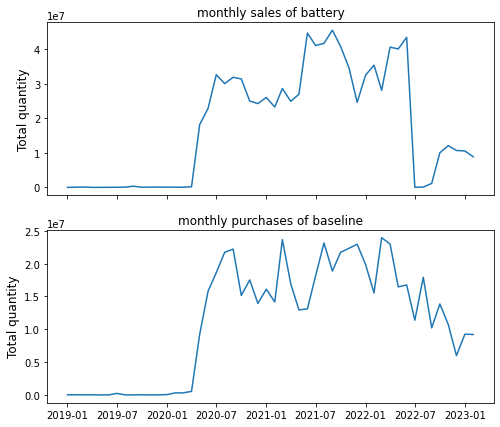

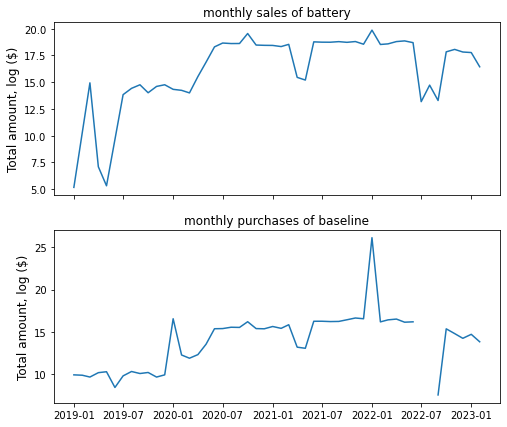

853710 32554 r=0.814 (n=48, p=0.000)
830242 143 r=0.168 (n=38, p=0.312)
630790 1940 r=0.684 (n=48, p=0.000)
848120 3326 r=0.708 (n=42, p=0.000)
490199 111351 r=0.717 (n=39, p=0.000)


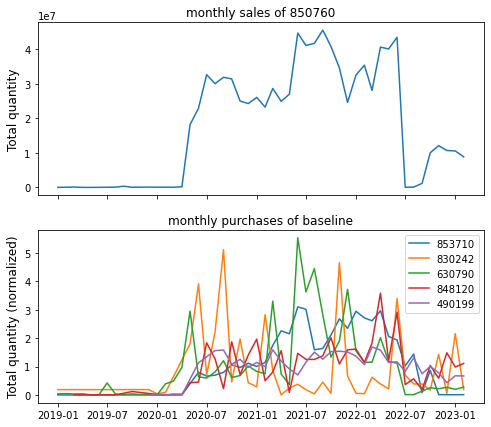

wistron: supply name is battery; buy name is baseline
Early termination for wistron due to data shortage. 
hp: supply name is battery; buy name is baseline
Supply len is 4628, buy len is 503


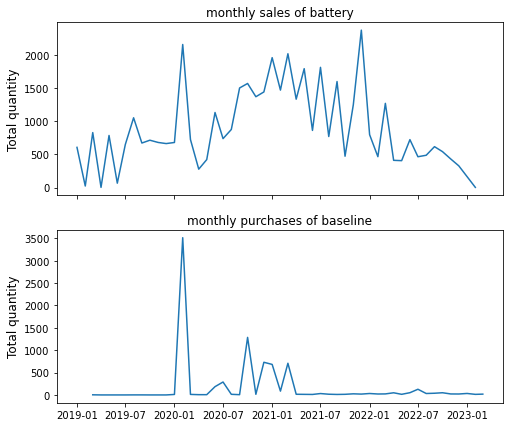

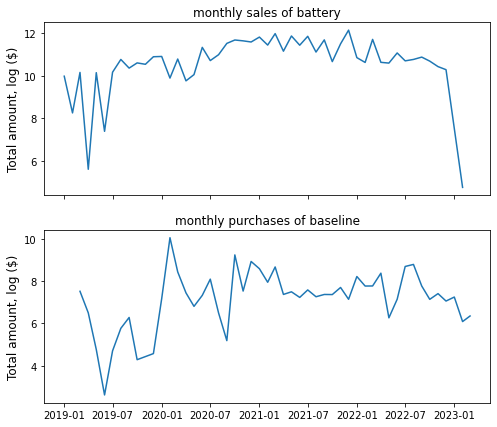

853710 472 r=-0.059 (n=46, p=0.697)
830242 0
630790 28
848120 2
490199 1


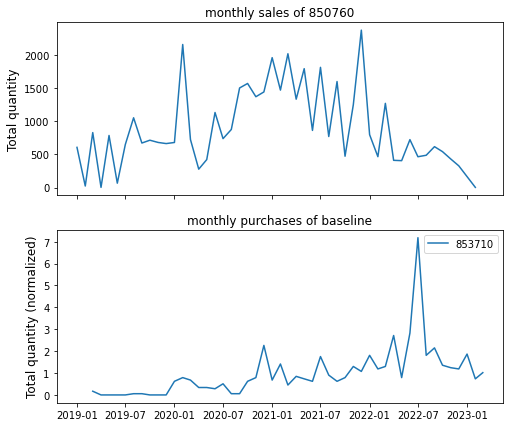

elentec: supply name is battery; buy name is baseline
Early termination for elentec due to data shortage. 
itm: supply name is battery; buy name is baseline
Supply len is 1513, buy len is 543


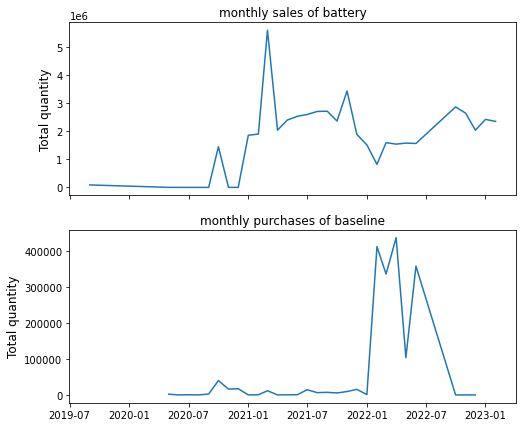

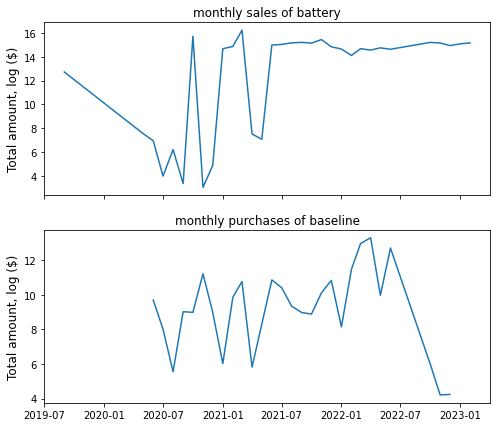

853710 325 r=-0.100 (n=27, p=0.619)
830242 36
630790 64
848120 118 r=0.279 (n=19, p=0.248)
490199 0


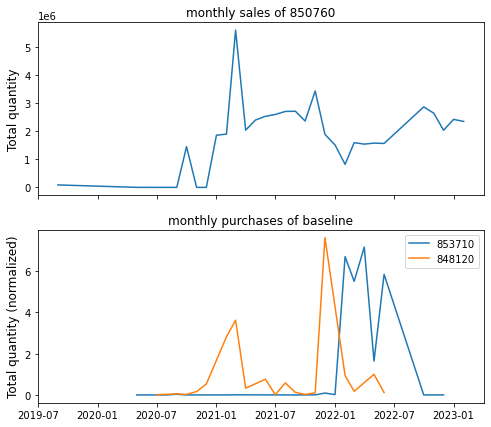

luxshare: supply name is battery; buy name is baseline
Supply len is 505, buy len is 192950


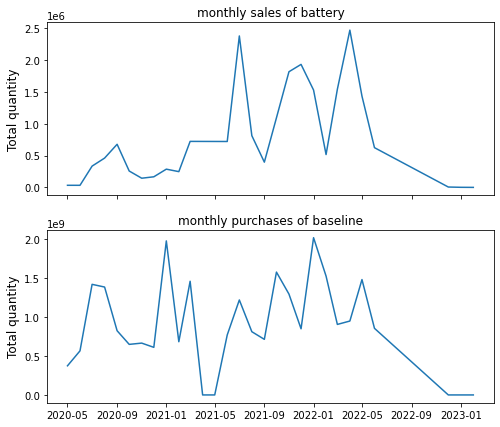

853710 723 r=0.328 (n=25, p=0.109)
830242 0
630790 65
848120 32
490199 0


apple: supply name is battery; buy name is baseline
Early termination for apple due to data shortage. 
lg: supply name is battery; buy name is baseline
Supply len is 1260, buy len is 11359


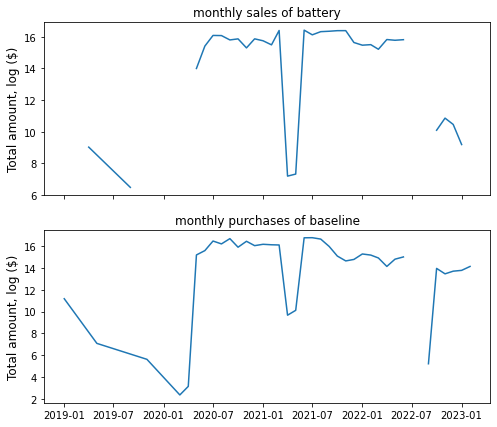

853710 11232 r=0.658 (n=35, p=0.000)
830242 3
630790 88
848120 20
490199 16


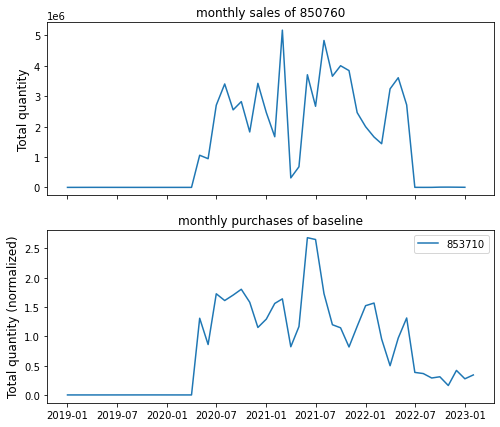

techtronic: supply name is battery; buy name is baseline
Supply len is 804, buy len is 310715


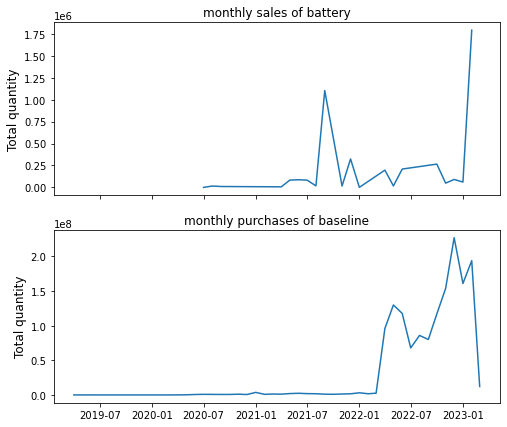

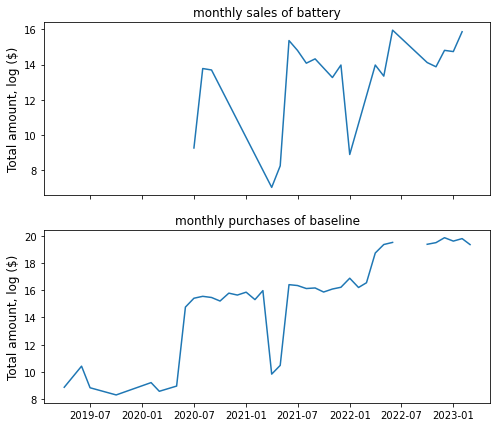

853710 27760 r=0.157 (n=20, p=0.508)
830242 0
630790 232 r=-0.065 (n=10, p=0.859)
848120 0
490199 851 r=-0.237 (n=13, p=0.436)


hansol: supply name is battery; buy name is baseline
Early termination for hansol due to data shortage. 
compal: supply name is battery; buy name is baseline
Supply len is 244, buy len is 345


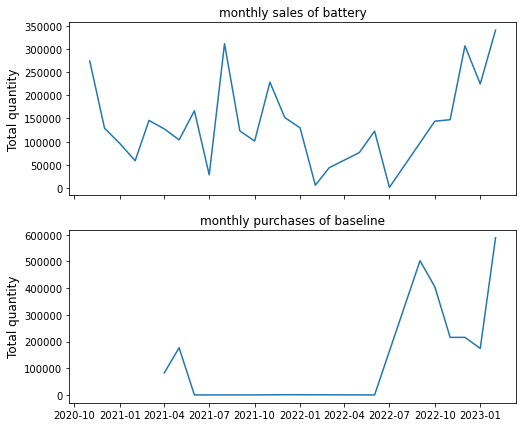

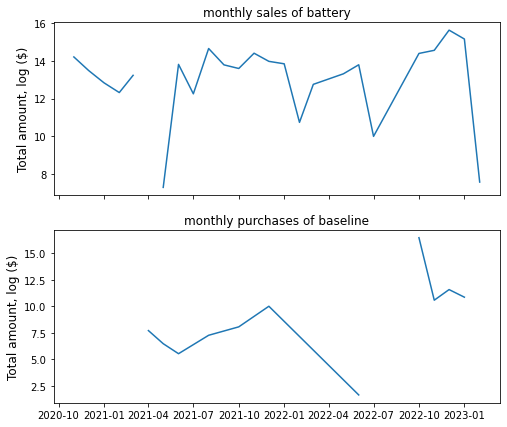

853710 68
830242 0
630790 24
848120 0
490199 253 r=0.748 (n=6, p=0.088)


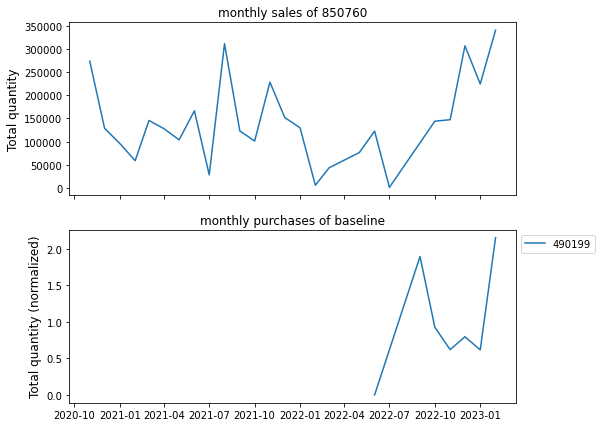

truper: supply name is battery; buy name is baseline
Supply len is 228, buy len is 2068


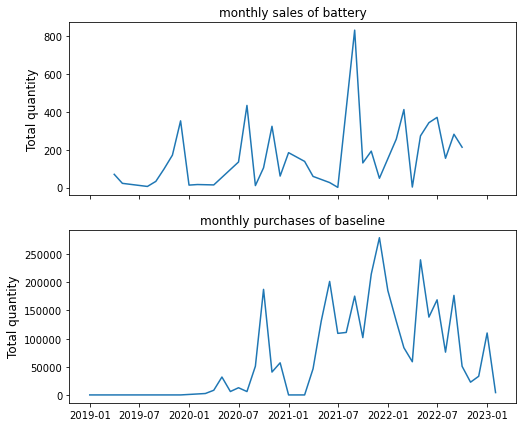

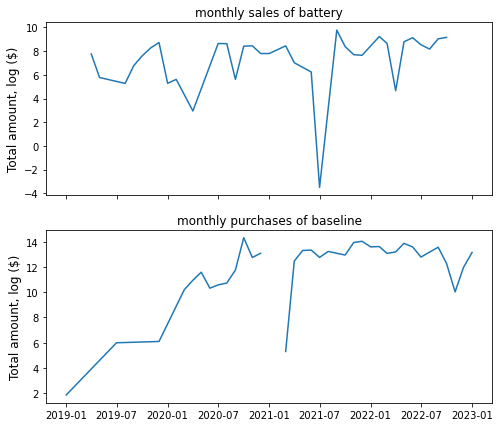

853710 69
830242 1179 r=0.180 (n=25, p=0.389)
630790 819 r=0.009 (n=26, p=0.965)
848120 1
490199 0


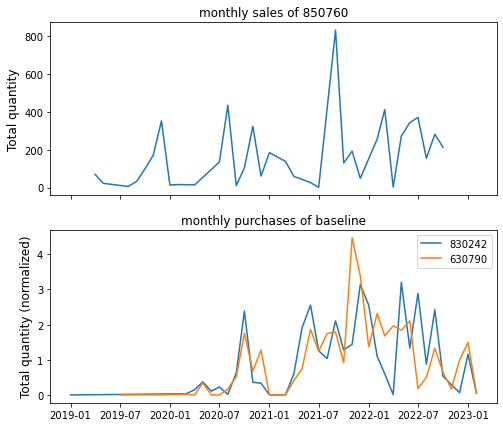

In [21]:
temp = []
SUPPLY_PROD='battery'
BUY_PROD=BASELINE_PROD

for csv_name in company_regex:
    supply_df, buy_df, early_termination = get_supply_buy_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
    if early_termination:
        print(f"Early termination for {csv_name} due to data shortage. ")
        continue
    temp.append(csv_name)
    
    supply_df, buy_df = add_transaction_time(supply_df=supply_df, buy_df=buy_df)
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly', csv_name=csv_name)
    summary_df = compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="monthly", csv_name=csv_name)
    summary_df = pd.DataFrame(summary_df, index=[0])
    summary_df.to_csv(f"./summary/{csv_name}_summary_baseline.csv", sep=',')
    del supply_df, buy_df

In [22]:
company_regex = temp.copy()
print(company_regex)
del temp

['samsung', 'hp', 'itm', 'luxshare', 'lg', 'techtronic', 'compal', 'truper']


### Smoothing Analysis

samsung: supply name is battery; buy name is baseline
Supply len is 47426, buy len is 149314


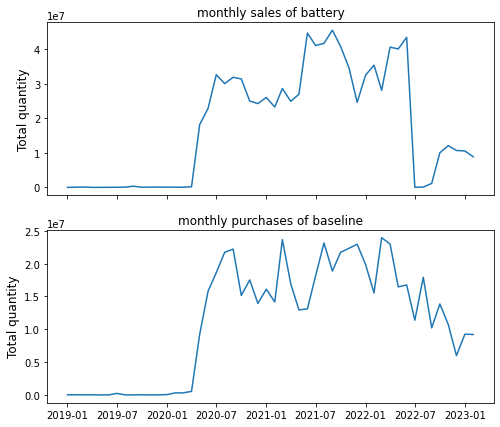

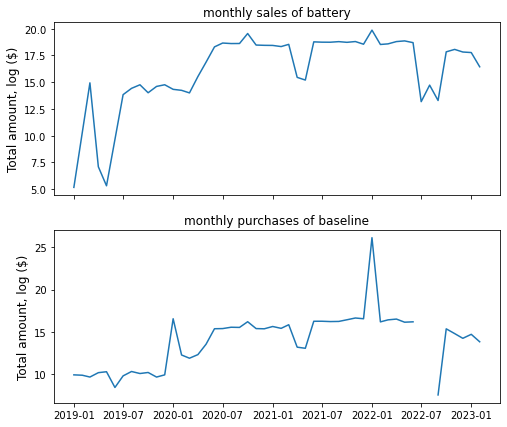

853710 32554 r=0.613 (n=825, p=0.000)
830242 143 r=0.135 (n=106, p=0.166)
630790 1940 r=0.509 (n=513, p=0.000)
848120 3326 r=0.028 (n=352, p=0.599)
490199 111351 r=0.173 (n=679, p=0.000)


hp: supply name is battery; buy name is baseline
Supply len is 4628, buy len is 503


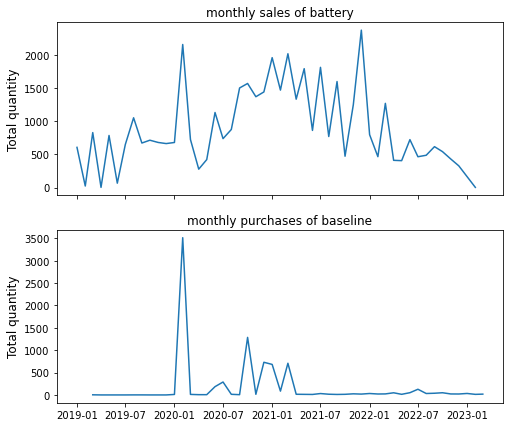

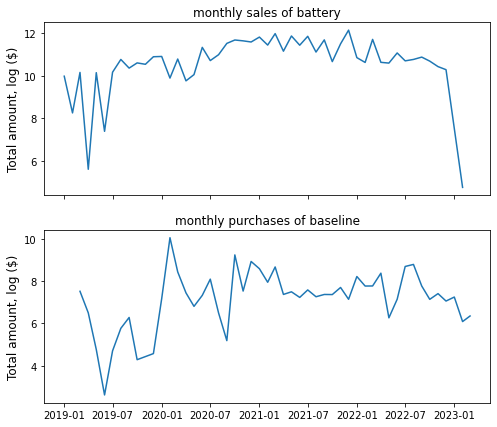

853710 472 r=-0.045 (n=58, p=0.740)
830242 0
630790 28
848120 2
490199 1


itm: supply name is battery; buy name is baseline
Supply len is 1513, buy len is 543


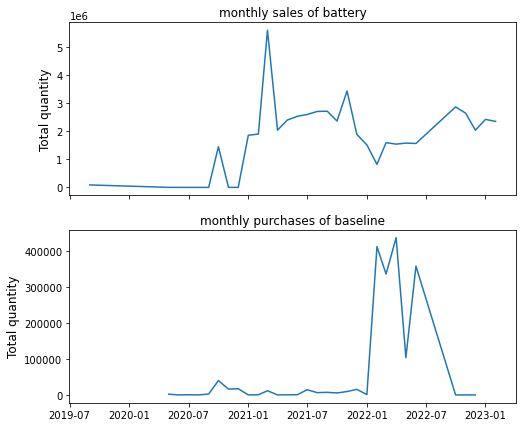

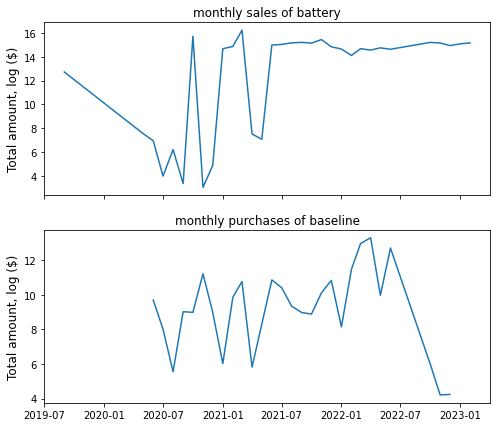

853710 325 r=-0.348 (n=79, p=0.002)
830242 36
630790 64
848120 118 r=-0.351 (n=29, p=0.062)
490199 0


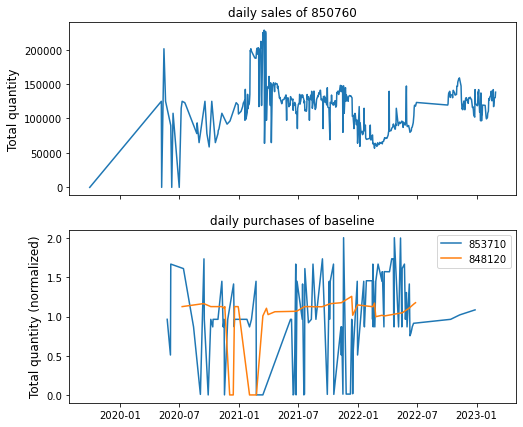

luxshare: supply name is battery; buy name is baseline
Supply len is 505, buy len is 192950


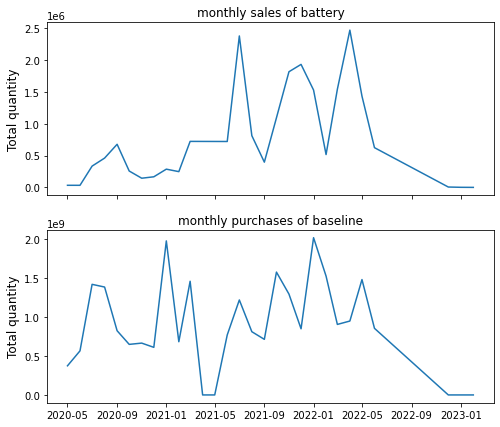

853710 723 r=0.291 (n=42, p=0.062)
830242 0
630790 65
848120 32
490199 0


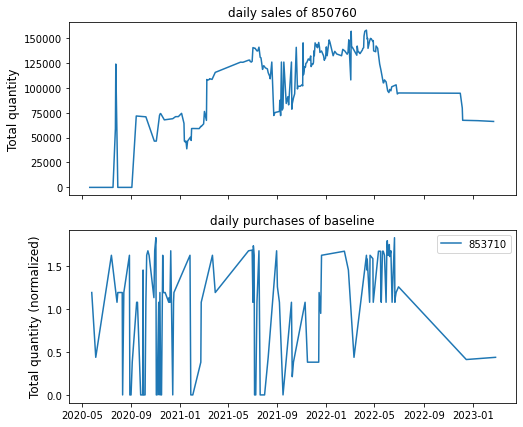

lg: supply name is battery; buy name is baseline
Supply len is 1260, buy len is 11359


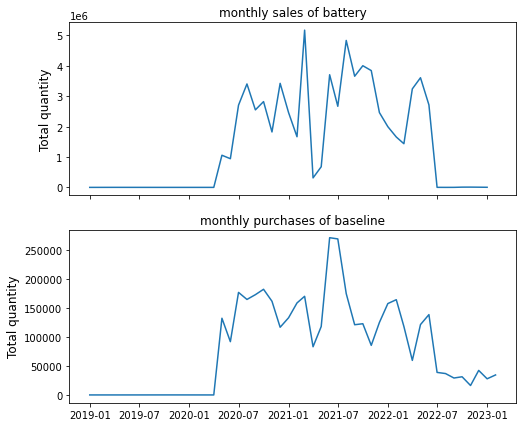

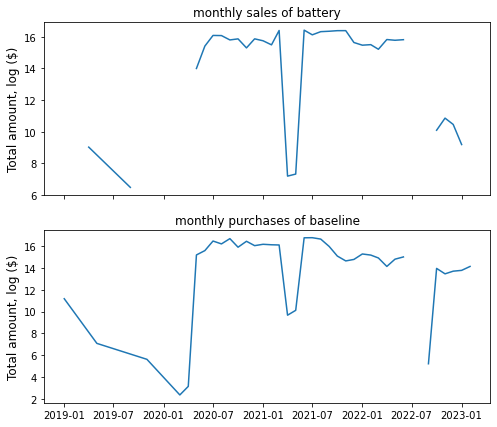

853710 11232 r=0.232 (n=405, p=0.000)
830242 3
630790 88
848120 20
490199 16


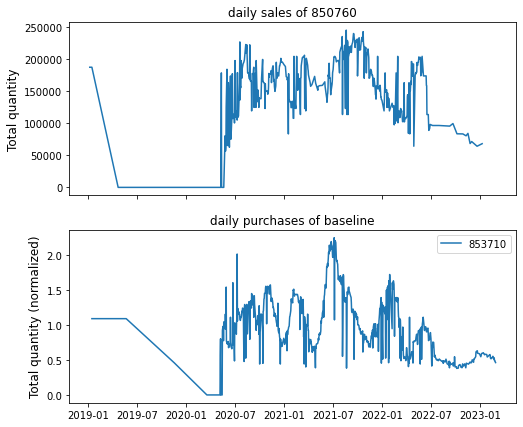

techtronic: supply name is battery; buy name is baseline
Supply len is 804, buy len is 310715


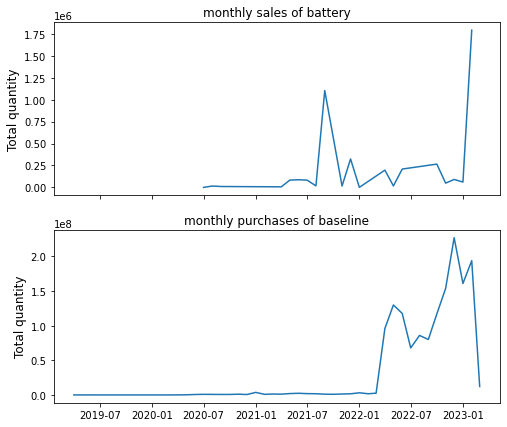

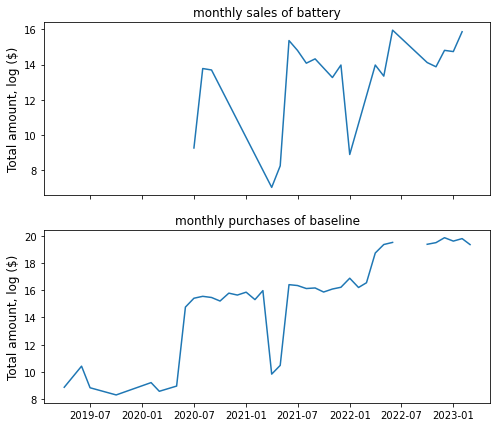

853710 27760 r=0.019 (n=211, p=0.779)
830242 0
630790 232 r=-0.077 (n=20, p=0.748)
848120 0
490199 851 r=-0.565 (n=22, p=0.006)


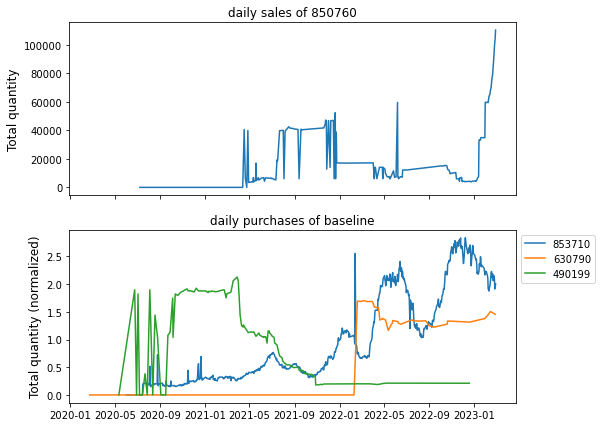

compal: supply name is battery; buy name is baseline
Supply len is 244, buy len is 345


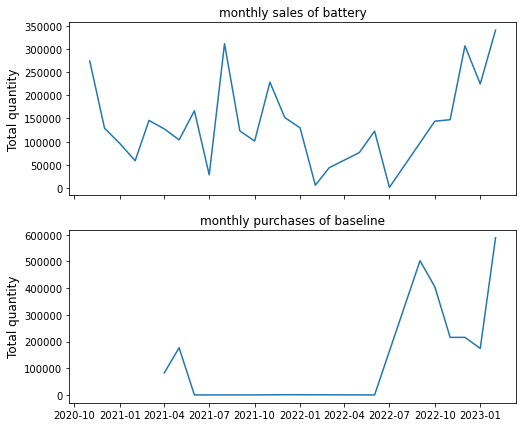

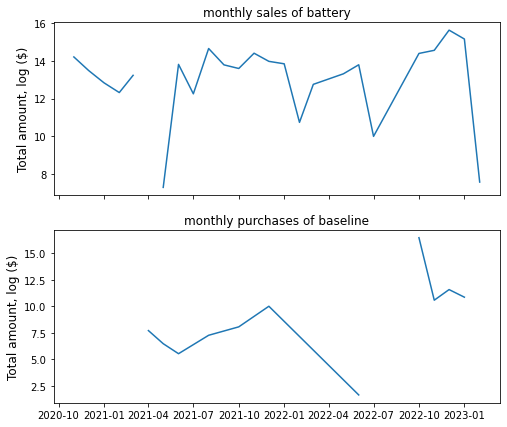

853710 68
830242 0
630790 24
848120 0
490199 253 r=0.714 (n=13, p=0.006)


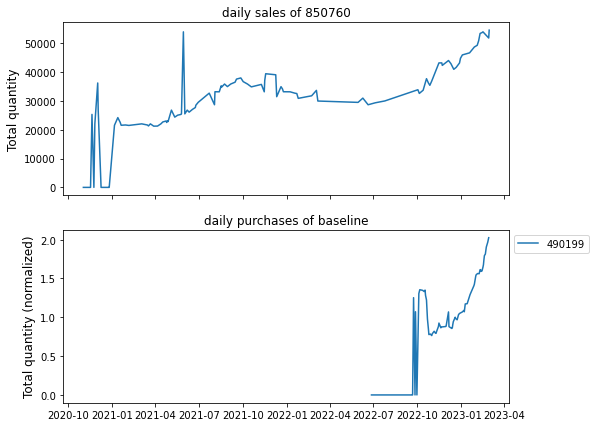

truper: supply name is battery; buy name is baseline
Supply len is 228, buy len is 2068


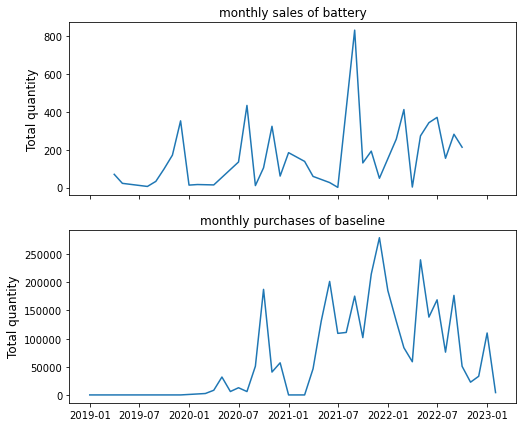

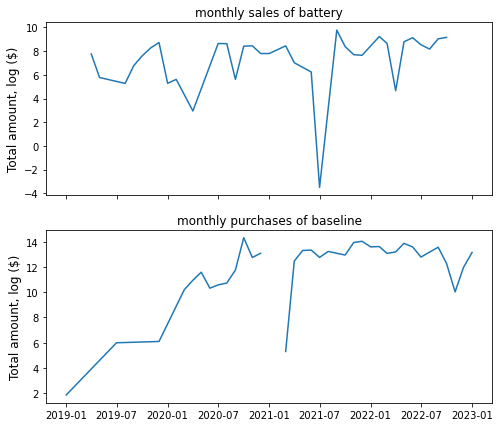

853710 69
830242 1179 r=-0.535 (n=18, p=0.022)
630790 819 r=0.166 (n=16, p=0.538)
848120 1
490199 0


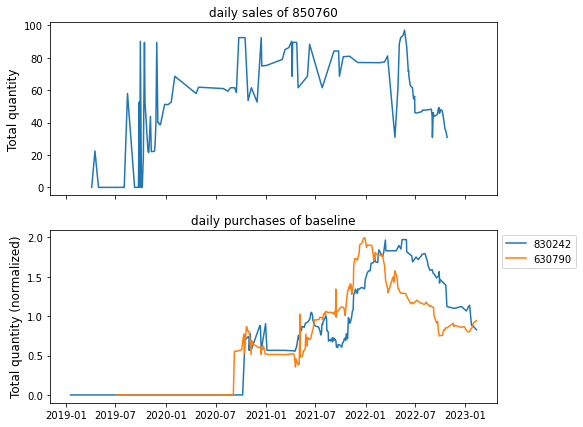

In [23]:
temp = []
SUPPLY_PROD='battery'
BUY_PROD=BASELINE_PROD
num_before, num_after = 15, 15

for csv_name in company_regex:
    supply_df, buy_df, early_termination = get_supply_buy_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
    if early_termination:
        print(f"Early termination for {csv_name} due to data shortage. ")
        continue
    temp.append(csv_name)
    
    supply_df, buy_df = add_transaction_time(supply_df=supply_df, buy_df=buy_df)
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly', csv_name=csv_name)
    summary_df = compare_sale_purchase_quantity_per_hscode_smooth(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, 
                                                                  time='daily', num_before=num_before, num_after=num_after, csv_name=csv_name)
    summary_df = pd.DataFrame(summary_df, index=[0])
    summary_df.to_csv(f"./summary/{csv_name}_smooth_{num_before}-{num_after}_summary_baseline.csv", sep=',')
    del supply_df, buy_df

In [24]:
company_regex = temp.copy()
print(company_regex)
del temp

['samsung', 'hp', 'itm', 'luxshare', 'lg', 'techtronic', 'compal', 'truper']


## Summary Table
summary statistics of time series correlations: battery-bms, battery-baseline

In [26]:
# Build summary table
dfs = []
for company in company_regex: 
    summary = pd.read_csv(f'./summary/{company}_summary.csv').set_index('group')
    baseline_summary = pd.read_csv(f'./summary/{company}_summary_baseline.csv').set_index('group')
    summary_smooth = pd.read_csv(f'./summary/{company}_smooth_15-15_summary.csv').set_index('group')
    baseline_summary_smooth = pd.read_csv(f'./summary/{company}_smooth_15-15_summary_baseline.csv').set_index('group')
    
    df = pd.concat([summary, baseline_summary, summary_smooth, baseline_summary_smooth], axis=1)
    df = df.drop(['Unnamed: 0'], axis=1)
    dfs.append(df)

df = pd.concat(dfs, axis=0) 
df1 = df.T
pd.set_option('display.max_rows', 100)
display(df1)

group                                                    samsung   
# of supply txn battery_850760                      47426.000000  \
# of buy txn bms_all                               483108.000000   
corr battery_850760, bms_all smooth_0_0                 0.882603   
# of supply txn bms_850450                          86582.000000   
corr battery_850760, bms_850450 smooth_0_0              0.838512   
# of supply txn bms_850730                              1.000000   
corr battery_850760, bms_850730 smooth_0_0                   NaN   
# of supply txn bms_850780                             86.000000   
corr battery_850760, bms_850780 smooth_0_0                   NaN   
# of supply txn bms_850790                           4680.000000   
corr battery_850760, bms_850790 smooth_0_0              0.910218   
# of supply txn bms_853222                           3537.000000   
corr battery_850760, bms_853222 smooth_0_0              0.735601   
# of supply txn bms_853223                            896.000000   
corr battery_850760, bms_853223 smooth_0_0             -0.028741   
# of supply txn bms_853321                         119285.000000   
corr battery_850760, bms_853321 smooth_0_0              0.856625   
# of supply txn bms_853340                           9184.000000   
corr battery_850760, bms_853340 smooth_0_0              0.765975   
# of supply txn bms_853630                           1320.000000   
corr battery_850760, bms_853630 smooth_0_0              0.541062   
# of supply txn bms_853641                            720.000000   
corr battery_850760, bms_853641 smooth_0_0              0.652774   
# of supply txn bms_853890                           1982.000000   
corr battery_850760, bms_853890 smooth_0_0              0.832066   
# of supply txn bms_854190                              1.000000   
corr battery_850760, bms_854190 smooth_0_0                   NaN   
# of supply txn bms_854239                         132787.000000   
corr battery_850760, bms_854239 smooth_0_0              0.913158   
# of supply txn bms_854290                            455.000000   
corr battery_850760, bms_854290 smooth_0_0              0.104796   
# of supply txn bms_854411                            637.000000   
corr battery_850760, bms_854411 smooth_0_0              0.334061   
# of supply txn bms_854442                          78900.000000   
corr battery_850760, bms_854442 smooth_0_0              0.862634   
# of supply txn bms_854449                          42055.000000   
corr battery_850760, bms_854449 smooth_0_0              0.771440   
# of supply txn battery_850760                      47426.000000   
# of buy txn baseline_all                          149314.000000   
corr battery_850760, baseline_all smooth_0_0            0.839290   
# of supply txn baseline_853710                     32554.000000   
corr battery_850760, baseline_853710 smooth_0_0         0.814486   
# of supply txn baseline_830242                       143.000000   
corr battery_850760, baseline_830242 smooth_0_0         0.168444   
# of supply txn baseline_630790                      1940.000000   
corr battery_850760, baseline_630790 smooth_0_0         0.684095   
# of supply txn baseline_848120                      3326.000000   
corr battery_850760, baseline_848120 smooth_0_0         0.707537   
# of supply txn baseline_490199                    111351.000000   
corr battery_850760, baseline_490199 smooth_0_0         0.716926   
# of supply txn battery_850760                      47426.000000   
# of buy txn bms_all                               483108.000000   
corr battery_850760, bms_all smooth_15_15               0.697707   
# of supply txn bms_850450                          86582.000000   
corr battery_850760, bms_850450 smooth_15_15            0.465373   
# of supply txn bms_850730                              1.000000   
corr battery_850760, bms_850730 smooth_15_15                 NaN   
# of supply txn bms_850780                             8

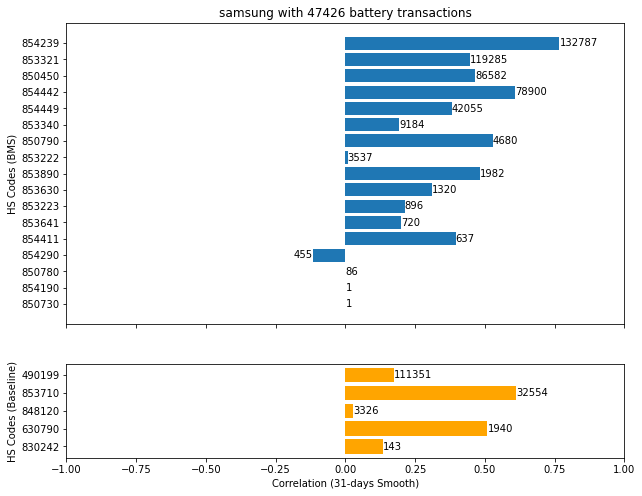

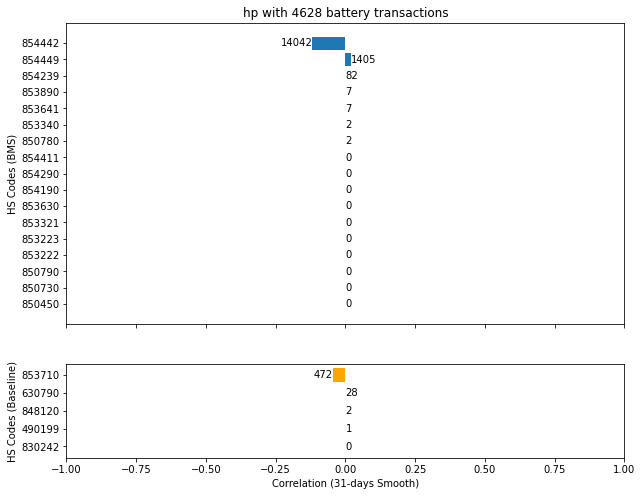

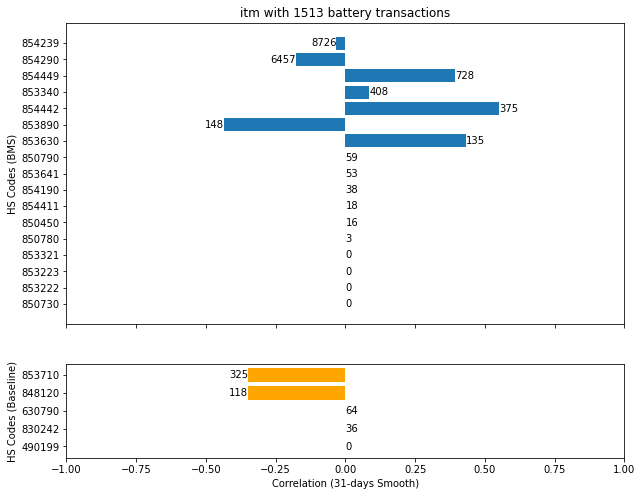

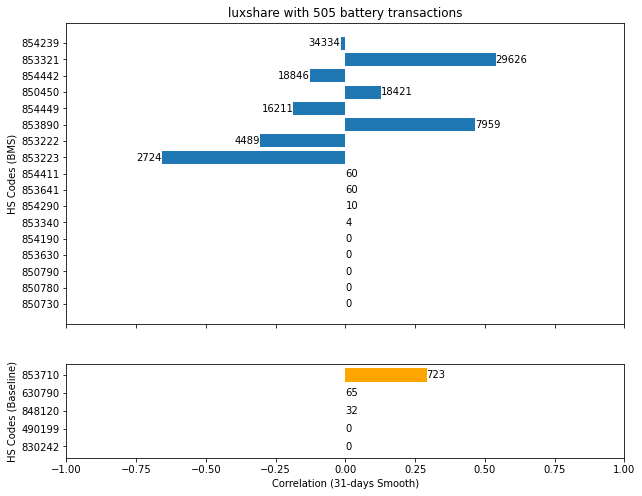

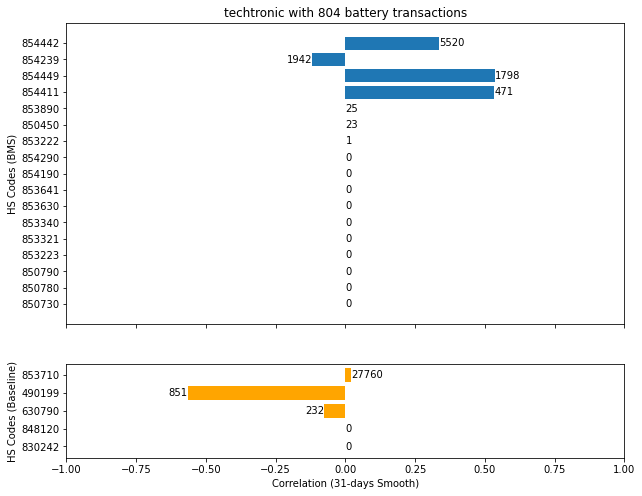

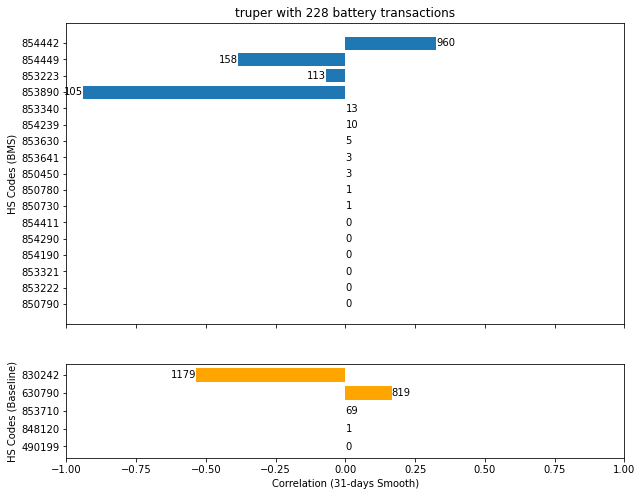

In [29]:
# Visualization
battery_txn = []
bms_txn = []
baseline_txn = []
for company in company_regex: 
    num_battery_txn, num_bms_txn, num_baseline_txn = plot_summary(company)
    battery_txn.append(num_battery_txn)
    bms_txn.append(num_bms_txn)
    baseline_txn.append(num_baseline_txn)

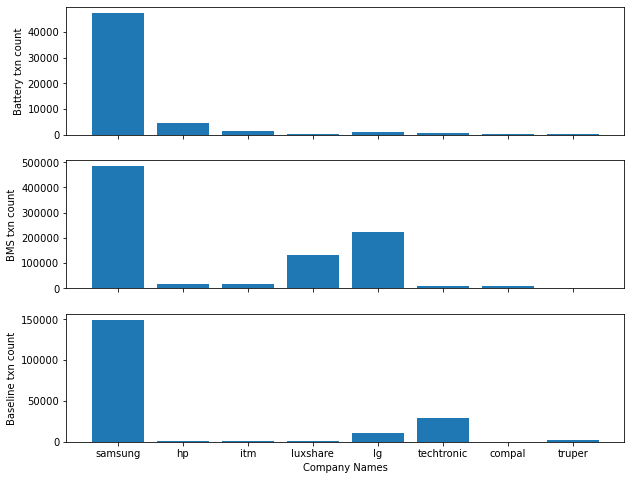

In [31]:
# Evaluate Number of Transactions: Battery, BMS, Baseline per company
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
ax = axes[0]
ax.set_ylabel("Battery txn count")
g = ax.bar(company_regex, battery_txn)

ax = axes[1]
ax.set_ylabel("BMS txn count")
g = ax.bar(company_regex, bms_txn)

ax = axes[2]
ax.set_ylabel("Baseline txn count")
g = ax.bar(company_regex, baseline_txn)


ax.set_xlabel("Company Names")
plt.show()

## TBD: Demonstrate Database Inconsistency

In [ ]:
# Problem: there are rows that exist in index_hs6 but not in logistic_data
tx_col = "supplier_t"
companies = ["%neway %"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from logistic_data where ({tx_string} and hs_code like '{hs}%');"
df = rs.query_df(query)

tx_col = "buyer_t"
companies = ["globe exim"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from logistic_data where ({tx_string} and hs_code like '{hs}%');"
df2 = rs.query_df(query)

tx_col = "supplier_t"
companies = ["%neway %"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from index_hs6 where ({tx_string} and hs6 like '{hs}%');"
df_1 = rs.query_df(query)